In [240]:
import time
import static
from difflib import get_close_matches
from scipy.sparse import triu
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from collections import Counter
from itertools import combinations
import itertools
from datetime import datetime
import networkx as nx
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis.lda_model
import re
from scholarly import scholarly
import requests
import glob
import bibtexparser

# Campos de df base

In [241]:
fields = [
    "fuente", "authors", "author_full_names", "author_id", "title", "year", "source_title", "volume", "issue",
    "art", "page_start", "page_end", "page_count", "cited_by", "DOI", "link", "abstract", "author_keywords",
    "index_keywords", "document_type", "publication_stage", "open_access", "source", "EID"
]

# Busqueda en bases de datos academicas

## Scopus

In [242]:
# Importar el archivo CSV exportado desde Scopus
scopus_df = pd.read_csv("./csv/scopus.csv", delimiter=',')
print("Dimensiones del archivo Scopus:", scopus_df.shape)

Dimensiones del archivo Scopus: (165, 41)


In [243]:
# --- Mapeo automático de nombres de columnas ---
def auto_column_map(fields, columns, cutoff=0.7):
    mapping = {}
    for f in fields:
        match = get_close_matches(f, columns, n=1, cutoff=cutoff)
        if match:
            mapping[match[0]] = f
    return mapping
column_map = auto_column_map(fields, scopus_df.columns)
# print("Mapeo detectado:")
# for k, v in column_map.items():
    # print(f"{k} -> {v}")
scopus_df_renamed = scopus_df.rename(columns=column_map)
scopus_df_filtered = scopus_df_renamed[[col for col in fields if col in scopus_df_renamed.columns]]

In [244]:
scopus_df_filtered = scopus_df_filtered.reindex(columns=fields)
print("Columnas finales en scopus_df_filtered:")
print(scopus_df_filtered.columns.tolist())
print("Dimensiones del DataFrame filtrado:", scopus_df_filtered.shape)
scopus_df_filtered.head()

Columnas finales en scopus_df_filtered:
['fuente', 'authors', 'author_full_names', 'author_id', 'title', 'year', 'source_title', 'volume', 'issue', 'art', 'page_start', 'page_end', 'page_count', 'cited_by', 'DOI', 'link', 'abstract', 'author_keywords', 'index_keywords', 'document_type', 'publication_stage', 'open_access', 'source', 'EID']
Dimensiones del DataFrame filtrado: (165, 24)


fuente                                            authors  \
0     NaN  H., Su, Huan; M., Gu, Mengli; Z., Qu, Zechao; ...   
1     NaN  I., Baek, Insuck; M., Cha, Min-hyeok; S., Lim,...   
2     NaN            L., Hssaini, Lahcen; R., Razouk, Rachid   
3     NaN       S., Prakadeswaran, S.; A.B., Banu, A. Bazila   
4     NaN  J., Sendrowski, Janek; T.M., Bataillon, Thomas...   

                                   author_full_names  author_id  \
0  Su, Huan (58700933400); Gu, Mengli (5886674590...        NaN   
1  Baek, Insuck (55414110300); Cha, Min-hyeok (57...        NaN   
2  Hssaini, Lahcen (57209320167); Razouk, Rachid ...        NaN   
3  Prakadeswaran, S. (59671547900); Banu, A. Bazi...        NaN   
4  Sendrowski, Janek (57474084100); Bataillon, Th...        NaN   

                                               title  year  \
0  Discovery of antimicrobial peptides from Bacil...  2025   
1  Integrated phenotypic analysis, predictive mod...  2025   
2  Mid-FTIR and machine learning for predicting f...  2025   
3  Gaussian regressed generative adversarial netw...  2025   
4  In silico prediction of variant effects: promi...  2025   

                                        source_title volume issue  art  ...  \
0  Chemical and Biological Technologies in Agricu...     12     1  NaN  ...   
1                                  BMC Plant Biology     25     1  NaN  ...   
2                                Analytical Sciences     41     9  NaN  ...   
3           Biomedical Signal Processing and Control    106   NaN  NaN  ...   
4                   Theoretical and Applied Genetics    138     8  NaN  ...   

                          DOI  \
0  10.1186/s40538-025-00751-9   
1  10.1186/s12870-025-07128-y   
2  10.1007/s44211-025-00814-9   
3  10.1016/j.bspc.2025.107761   
4  10.1007/s00122-025-04973-1   

                                                link  \
0  https://www.scopus.com/inward/record.uri?eid=2...   
1  https://www.scopus.com/inward/record.uri?eid=2...   
2  https://www.scopus.com/inward/record.uri?eid=2...   
3  https://www.scopus.com/inward/record.uri?eid=2...   
4  https://www.scopus.com/inward/record.uri?eid=2...   

                                            abstract  \
0  Background: Antimicrobial peptides (AMPs) have...   
1  Background: Cacao (Theobroma cacao L.) breedin...   
2  Predicting leaf mineral composition is critica...   
3  Identifying diseases from images of plant leav...   
4  Key message: Sequence-based AI models show gre...   

                                     author_keywords  \
0  Antimicrobial Peptides; Bacillus; Deep Learnin...   
1  Cacao; Genetics; Growth, Development And Aging...   
2  Fig Leaves; Ftir-atr Spectroscopy; Gradient Bo...   
3  Cassava Plant Leaf Disease Diagnosis; Continuo...   
4  Genes; Learning Systems; Molecular Biology; Pe...   

                                      index_keywords document_type  \
0                                                NaN       Article   
1  cacao; genetics; growth, development and aging...       Article   
2  Agricultural machinery; Agriculture; Forecasti...       Article   
3  Adversarial networks; Cassavum plant leaf dise...       Article   
4  Genes; Learning systems; Molecular biology; Pe...        Review   

  publication_stage                               open_access  source  \
0             Final         All Open Access; Gold Open Access  Scopus   
1             Final                                       NaN  Scopus   
2             Final                                       NaN  Scopus   
3             Final                                       NaN  Scopus   
4             Final  All Open Access; Hybrid Gold Open Access  Scopus   

                   EID  
0   2-s2.0-86000726174  
1  2-s2.0-105012943547  
2  2-s2.0-105009402473  
3   2-s2.0-86000145242  
4  2-s2.0-105011994604  

[5 rows x 24 columns]

## IEEE


In [245]:
# Importar el archivo CSV exportado desde IEEE
ieee_df = pd.read_csv("./csv/ieee.csv", delimiter=',')
print("Dimensiones del archivo IEEE:", ieee_df.shape)

Dimensiones del archivo IEEE: (31, 28)


In [246]:
# --- Mapeo automático de nombres de columnas ---
def auto_column_map(fields, columns, cutoff=0.7):
    mapping = {}
    for f in fields:
        match = get_close_matches(f, columns, n=1, cutoff=cutoff)
        if match:
            mapping[match[0]] = f
    return mapping
column_map = auto_column_map(fields, ieee_df.columns)
# print("Mapeo detectado:")
# for k, v in column_map.items():
#     print(f"{k} -> {v}")
ieee_df_renamed = ieee_df.rename(columns=column_map)
ieee_df_filtered = ieee_df_renamed[[col for col in fields if col in ieee_df_renamed.columns]]


In [247]:
ieee_df_filtered = ieee_df_filtered.reindex(columns=fields)
print("Columnas finales en ieee_df_filtered:")
print(ieee_df_filtered.columns.tolist())
print("Dimensiones del DataFrame filtrado:", ieee_df_filtered.shape)
ieee_df_filtered.head()

Columnas finales en ieee_df_filtered:
['fuente', 'authors', 'author_full_names', 'author_id', 'title', 'year', 'source_title', 'volume', 'issue', 'art', 'page_start', 'page_end', 'page_count', 'cited_by', 'DOI', 'link', 'abstract', 'author_keywords', 'index_keywords', 'document_type', 'publication_stage', 'open_access', 'source', 'EID']
Dimensiones del DataFrame filtrado: (31, 24)


fuente                                            authors  \
0     NaN                                  S. Gupta; P. Rani   
1     NaN              M. Bahrami; A. Pourhatami; M. Maboodi   
2     NaN  B. Gupta; S. Agarwal; A. Srivastava; Aaradhya;...   
3     NaN  V. Ebenezer; A. A. Daniel; P. G. J. Lillipushp...   
4     NaN           S. Haris; K. S. Sai; N. S. Rani; P. B. R   

   author_full_names  author_id  title  year  source_title  volume  issue  \
0                NaN        NaN    NaN   NaN           NaN     NaN    NaN   
1                NaN        NaN    NaN   NaN           NaN     NaN    NaN   
2                NaN        NaN    NaN   NaN           NaN     NaN    NaN   
3                NaN        NaN    NaN   NaN           NaN     NaN    NaN   
4                NaN        NaN    NaN   NaN           NaN     NaN    NaN   

   art  ...                                DOI  link  \
0  NaN  ...  10.1109/DELCON64804.2024.10866614   NaN   
1  NaN  ...    10.1109/MVIP62238.2024.10491178   NaN   
2  NaN  ...    10.1109/ICDT63985.2025.10986310   NaN   
3  NaN  ...   10.1109/ICESC57686.2023.10193447   NaN   
4  NaN  ...  10.1109/ICAAIC56838.2023.10141055   NaN   

                                            abstract  \
0  Apple is a common fruit rich in antioxidants, ...   
1  Tomato, a vital food crop enriched with essent...   
2  Agriculture is important to feeding the world'...   
3  Peanut is a key food commodity, and diseases o...   
4  Nutrition deficiency in plants is a major prob...   

                                     author_keywords index_keywords  \
0  Apple Fungal Diseases;Machine Learning;Rust;Sc...            NaN   
1  detection;tomato;transfer learning;leaf diseas...            NaN   
2  Machine Learning;Crop and Fertilizer recommend...            NaN   
3  Convolutional neural network;Peanut Leaf;Augme...            NaN   
4  Convolutional Neural Network;Nutritional Defic...            NaN   

   document_type                                  publication_stage  \
0            NaN  2024 3rd Edition of IEEE Delhi Section Flagshi...   
1            NaN  2024 13th Iranian/3rd International Machine Vi...   
2            NaN  2025 3rd International Conference on Disruptiv...   
3            NaN  2023 4th International Conference on Electroni...   
4            NaN  2023 2nd International Conference on Applied A...   

  open_access  source  EID  
0         NaN     NaN  NaN  
1         NaN     NaN  NaN  
2         NaN     NaN  NaN  
3         NaN     NaN  NaN  
4         NaN     NaN  NaN  

[5 rows x 24 columns]

## Web o Science


In [248]:
# Importar el archivo Excel exportado desde Web of Science
wos_df = pd.read_excel("./csv/wos/wos.xls")
print("Dimensiones del archivo Web of Science:", wos_df.shape)

Dimensiones del archivo Web of Science: (159, 79)


In [249]:
# --- Mapeo automático de nombres de columnas ---
def auto_column_map(fields, columns, cutoff=0.7):
    mapping = {}
    for f in fields:
        match = get_close_matches(f, columns, n=1, cutoff=cutoff)
        if match:
            mapping[match[0]] = f
    return mapping
column_map = auto_column_map(fields, wos_df.columns)
print("Mapeo detectado:")
for k, v in column_map.items():
    print(f"{k} -> {v}")
wos_df_renamed = wos_df.rename(columns=column_map)
wos_df_filtered = wos_df_renamed[[col for col in fields if col in wos_df_renamed.columns]]

Mapeo detectado:
Authors -> authors
Source Title -> source_title
Volume -> volume
Issue -> issue
DOI -> DOI
Abstract -> abstract
Author Keywords -> author_keywords
Document Type -> document_type
Publication Date -> publication_stage


In [250]:
wos_df_filtered = wos_df_filtered.reindex(columns=fields)
print("Columnas finales en wos_df_filtered:")
print(wos_df_filtered.columns.tolist())
print("Dimensiones del DataFrame filtrado:", wos_df_filtered.shape)
wos_df_filtered.head()

Columnas finales en wos_df_filtered:
['fuente', 'authors', 'author_full_names', 'author_id', 'title', 'year', 'source_title', 'volume', 'issue', 'art', 'page_start', 'page_end', 'page_count', 'cited_by', 'DOI', 'link', 'abstract', 'author_keywords', 'index_keywords', 'document_type', 'publication_stage', 'open_access', 'source', 'EID']
Dimensiones del DataFrame filtrado: (159, 24)


fuente                                            authors  \
0     NaN  Rathor, Ajit Singh; Choudhury, Sushabhan; Shar...   
1     NaN  Salam, Abdus; Naznine, Mansura; Jahan, Nusrat;...   
2     NaN  Karthik, R.; Menaka, R.; Siddharth, M. V.; Hus...   
3     NaN  Li, Ruyue; Chen, Sishi; Matsumoto, Haruna; Gou...   
4     NaN  Mohapatra, Madhumini; Parida, Ami Kumar; Malli...   

   author_full_names  author_id  title  year                     source_title  \
0                NaN        NaN    NaN   NaN                          HELIYON   
1                NaN        NaN    NaN   NaN                      IEEE ACCESS   
2                NaN        NaN    NaN   NaN  NEURAL COMPUTING & APPLICATIONS   
3                NaN        NaN    NaN   NaN                         ABIOTECH   
4                NaN        NaN    NaN   NaN                        COMPUTERS   

   volume issue  art  ...                            DOI  link  \
0    10.0    15  NaN  ...  10.1016/j.heliyon.2024.e34998   NaN   
1    12.0   NaN  NaN  ...    10.1109/ACCESS.2024.3407153   NaN   
2    35.0    30  NaN  ...     10.1007/s00521-023-08943-w   NaN   
3     4.0     4  NaN  ...     10.1007/s42994-023-00126-4   NaN   
4    11.0     5  NaN  ...      10.3390/computers11050082   NaN   

                                            abstract  author_keywords  \
0  The substantial increase in the human populati...              NaN   
1  Mulberry leaves serve as the primary food sour...              NaN   
2  Cassava is a significant source of carbohydrat...              NaN   
3  The past few years have witnessed significant ...              NaN   
4  Botanical plants suffer from several types of ...              NaN   

  index_keywords  document_type publication_stage  open_access  source EID  
0            NaN        Article       AUG 15 2024          NaN     NaN NaN  
1            NaN        Article              2024          NaN     NaN NaN  
2            NaN        Article          OCT 2023          NaN     NaN NaN  
3            NaN         Review          DEC 2023          NaN     NaN NaN  
4            NaN        Article          MAY 2022          NaN     NaN NaN  

[5 rows x 24 columns]

## Google Scholar

In [251]:
def get_doi_from_crossref(title, author=None):
    # Construir la URL de búsqueda
    crossref_url = f"https://api.crossref.org/works?query.title={title}"
    if author:
        crossref_url += f"&query.author={author}"
    response = requests.get(crossref_url)
    data = response.json()
    if data.get('message', {}).get('items'):
        return data['message']['items'][0].get('DOI', None)
    return None

In [252]:
query = static.SCHOLAR_QUERY
search_results = scholarly.search_pubs(query)

results = []
for i, result in enumerate(search_results):
    if i >= 20:
        break
    bib = result.get('bib', {})
    row = {}
    for field in fields:
        if field == "fuente":
            row[field] = "Google Scholar"
        elif field == "authors":
            row[field] = bib.get('author', None)
        elif field == "title":
            row[field] = bib.get('title', None)
        elif field == "year":
            row[field] = bib.get('pub_year', None)
        elif field == "source_title":
            row[field] = bib.get('venue', None)
        elif field == "DOI":
            row[field] = bib.get('doi', None)
        elif field == "link":
            row[field] = result.get('pub_url', None)
        elif field == "abstract":
            row[field] = bib.get('abstract', None)
        elif field == "cited_by":
            row[field] = result.get('num_citations', None)
        else:
            row[field] = None
    results.append(row)

df_gs = pd.DataFrame(results)

In [253]:
for idx, row in df_gs[df_gs['DOI'].isnull()].iterrows():  # Solo los primeros 800
    title = row['title']
    author = row['authors']
    try:
        doi = get_doi_from_crossref(title, author)
        df_gs.at[idx, 'DOI'] = doi
    except Exception as e:
        print(f"Error en idx {idx}: {e}")
    time.sleep(0.5)  # Espera medio segundo entre peticiones


In [303]:
df_gs

fuente                                            authors  \
0   Google Scholar               [B Benmouna, R Pourdarbani, S Sabzi]   
1   Google Scholar                                  [SW Nixon, V Lee]   
2   Google Scholar          [C Yang, C Yang, Y Liang, H Yan, A Zhang]   
3   Google Scholar                [M Waseem, SM El-Bahy, MMH Maqbool]   
4   Google Scholar                       [J Li, Z Jia, S Wang, S Liu]   
5   Google Scholar             [A Chlingaryan, S Sukkarieh, B Whelan]   
6   Google Scholar       [J Chen, K de Hoogh, J Gulliver, B Hoffmann]   
7   Google Scholar         [IV Arinichev, SV Polyanskikh, GV Volkova]   
8   Google Scholar  [A Morellos, XE Pantazi, D Moshou, T Alexandri...   
9   Google Scholar    [B Feng, J Ma, Y Liu, L Wang, X Zhang, Y Zhang]   
10  Google Scholar          [M Wu, Z Song, Y Cui, Z Fu, K Hong, Q Li]   
11  Google Scholar                   [M Hu, QB Zhou, X Wang, FP Tang]   
12  Google Scholar                            [Á Gallegos, ME Gavito]   
13  Google Scholar            [D Mandal, R de Siqueira, L Longchamps]   
14  Google Scholar          [B Konara, M Krishnapillai, L Galagedara]   
15  Google Scholar             [AB Asad, A Paudel, S Kshetri, C Kang]   
16  Google Scholar                   [S Zhang, PE Lærke, MN Andersen]   
17  Google Scholar                    [SK Lam, B Pan, AK Qin, D Chen]   
18  Google Scholar  [T Haider, MS Farid, R Mahmood, A Ilyas, MH Khan]   
19  Google Scholar                  [T Paepae, PN Bokoro, K Kyamakya]   

   author_full_names author_id  \
0               None      None   
1               None      None   
2               None      None   
3               None      None   
4               None      None   
5               None      None   
6               None      None   
7               None      None   
8               None      None   
9               None      None   
10              None      None   
11              None      None   
12              None      None   
13              None      None   
14              None      None   
15              None      None   
16              None      None   
17              None      None   
18              None      None   
19              None      None   

                                                title  year  \
0   Attention mechanisms in convolutional neural n...  2023   
1   … of recent research in the United States on t...  1986   
2   Machine-learning enables nitrogen reduction re...  2025   
3   Designing a machine learning-optimized nitroge...  2025   
4   Pressure Characteristics in the Nitrogen-Seale...  2024   
5   Machine learning approaches for crop yield pre...  2018   
6   A comparison of linear regression, regularizat...  2019   
7   Rice fungal diseases recognition using modern ...  2021   
8   Machine learning based prediction of soil tota...  2016   
9   Application of machine learning approaches to ...  2024   
10  Machine Learning‐Assisted Design of Nitrogen‐R...  2025   
11  Study of liquid nitrogen insulation characteri...  2022   
12  Foliar Nitrogen Estimation with Artificial Int...  2024   
13  Machine learning and fluorosensing for estimat...  2024   
14  Recent Trends and Advances in Utilizing Digita...  2024   
15  Integrating Feature Selection and Machine Lear...  2025   
16  Combining biomass production model with machin...  2025   
17  Advancing agroecosystem modelling of nitrogen ...  2024   
18  A computer-vision-based approach for nitrogen ...  2021   
19  A virtual sensing concept for nitrogen and pho...  2022   

                      source_title volume issue   art  ...  \
0                      Electronics   None  None  None  ...   
1                               NA   None  None  None  ...   
2            Materials Chemistry …   None  None  None  ...   
3           Journal of Materials …   None  None  None  ...   
4                        Processes   None  None  None  ...   
5   Computers and electronics in …   None  None  None  ...   
6    

## ScienceDirect

In [304]:
bib_files = glob.glob('./csv/science_direct/*.bib')
bib_records = []
def bibtex_to_fields(entry, fields):
    # Mapeo básico de campos BibTeX a los de fields
    bib_map = {
        'title': 'title',
        'author': 'authors',
        'journal': 'source_title',
        'year': 'year',
        'doi': 'DOI',
        'abstract': 'abstract',
        'keywords': 'author_Keywords',
        'volume': 'volume',
        'number': 'issue',
        'pages': 'page_start', # Puede requerir split
        'url': 'link',
        'document_type': 'document_type',
    }
    row = {f: None for f in fields}
    for bib_key, field_key in bib_map.items():
        value = entry.get(bib_key)
        if value:
            if field_key == 'authors':
                row[field_key] = value.replace(' and ', '; ')
            elif field_key == 'page_start':
                # Si hay rango de páginas, separar inicio y fin
                pages = value.split('--') if '--' in value else value.split('-')
                row['page_start'] = pages[0]
                if len(pages) > 1:
                    row['page_end'] = pages[-1]
            else:
                row[field_key] = value
    row['fuente'] = 'ScienceDirect'
    return row
for bib_file in bib_files:
    with open(bib_file, encoding='utf-8') as bibtex_file:
        bib_database = bibtexparser.load(bibtex_file)
        for entry in bib_database.entries:
            bib_records.append(bibtex_to_fields(entry, fields))
sciencedirect_df = pd.DataFrame(bib_records).reindex(columns=fields)
print("Dimensiones del DataFrame de ScienceDirect:", sciencedirect_df.shape)

Dimensiones del DataFrame de ScienceDirect: (3, 24)


# Limpieza de datos 

In [305]:
# --- Unificar todos los DataFrames de las bases de datos ---
dfs_to_concat = []
# --- Unificar todos los DataFrames de las bases de datos ---
db_sources = {
    'scopus_df_filtered': 'Scopus',
    'ieee_df_filtered': 'IEEE',
    'wos_df_filtered': 'Web of Science',
    'df_gs': 'Google Scholar',
    'sciencedirect_df': 'ScienceDirect'
}

for df_name in ['scopus_df_filtered', 'ieee_df_filtered', 'wos_df_filtered', 'df_gs', 'sciencedirect_df']:
    if df_name in globals():
        df = globals()[df_name].copy()
        # Asignar el nombre de la base de datos en la columna 'fuente'
        df['fuente'] = db_sources[df_name]
        # Reindex para asegurar las mismas columnas
        dfs_to_concat.append(df.reindex(columns=fields))
unified_df = pd.concat(dfs_to_concat, ignore_index=True)
print("Dimensiones del DataFrame unificado:", unified_df.shape)
unified_df.head()

Dimensiones del DataFrame unificado: (378, 24)


fuente                                            authors  \
0  Scopus  H., Su, Huan; M., Gu, Mengli; Z., Qu, Zechao; ...   
1  Scopus  I., Baek, Insuck; M., Cha, Min-hyeok; S., Lim,...   
2  Scopus            L., Hssaini, Lahcen; R., Razouk, Rachid   
3  Scopus       S., Prakadeswaran, S.; A.B., Banu, A. Bazila   
4  Scopus  J., Sendrowski, Janek; T.M., Bataillon, Thomas...   

                                   author_full_names author_id  \
0  Su, Huan (58700933400); Gu, Mengli (5886674590...       NaN   
1  Baek, Insuck (55414110300); Cha, Min-hyeok (57...       NaN   
2  Hssaini, Lahcen (57209320167); Razouk, Rachid ...       NaN   
3  Prakadeswaran, S. (59671547900); Banu, A. Bazi...       NaN   
4  Sendrowski, Janek (57474084100); Bataillon, Th...       NaN   

                                               title  year  \
0  Discovery of antimicrobial peptides from Bacil...  2025   
1  Integrated phenotypic analysis, predictive mod...  2025   
2  Mid-FTIR and machine learning for predicting f...  2025   
3  Gaussian regressed generative adversarial netw...  2025   
4  In silico prediction of variant effects: promi...  2025   

                                        source_title volume issue  art  ...  \
0  Chemical and Biological Technologies in Agricu...     12     1  NaN  ...   
1                                  BMC Plant Biology     25     1  NaN  ...   
2                                Analytical Sciences     41     9  NaN  ...   
3           Biomedical Signal Processing and Control    106   NaN  NaN  ...   
4                   Theoretical and Applied Genetics    138     8  NaN  ...   

                          DOI  \
0  10.1186/s40538-025-00751-9   
1  10.1186/s12870-025-07128-y   
2  10.1007/s44211-025-00814-9   
3  10.1016/j.bspc.2025.107761   
4  10.1007/s00122-025-04973-1   

                                                link  \
0  https://www.scopus.com/inward/record.uri?eid=2...   
1  https://www.scopus.com/inward/record.uri?eid=2...   
2  https://www.scopus.com/inward/record.uri?eid=2...   
3  https://www.scopus.com/inward/record.uri?eid=2...   
4  https://www.scopus.com/inward/record.uri?eid=2...   

                                            abstract  \
0  Background: Antimicrobial peptides (AMPs) have...   
1  Background: Cacao (Theobroma cacao L.) breedin...   
2  Predicting leaf mineral composition is critica...   
3  Identifying diseases from images of plant leav...   
4  Key message: Sequence-based AI models show gre...   

                                     author_keywords  \
0  Antimicrobial Peptides; Bacillus; Deep Learnin...   
1  Cacao; Genetics; Growth, Development And Aging...   
2  Fig Leaves; Ftir-atr Spectroscopy; Gradient Bo...   
3  Cassava Plant Leaf Disease Diagnosis; Continuo...   
4  Genes; Learning Systems; Molecular Biology; Pe...   

                                      index_keywords document_type  \
0                                                NaN       Article   
1  cacao; genetics; growth, development and aging...       Article   
2  Agricultural machinery; Agriculture; Forecasti...       Article   
3  Adversarial networks; Cassavum plant leaf dise...       Article   
4  Genes; Learning systems; Molecular biology; Pe...        Review   

  publication_stage                               open_access  source  \
0             Final         All Open Access; Gold Open Access  Scopus   
1             Final                                       NaN  Scopus   
2             Final                                       NaN  Scopus   
3             Final                                       NaN  Scopus   
4             Final  All Open Access; Hybrid Gold Open Access  Scopus   

                   EID  
0   2-s2.0-86000726174  
1  2-s2.0-105012943547  
2  2-s2.0-105009402473  
3   2-s2.0-86000145242  
4  2-s2.0-105011994604  

[5 rows x 24 columns]

In [306]:
# --- Mostrar los registros con DOIs repetidos ---
duplicated_dois = unified_df['DOI'][unified_df['DOI'].duplicated(keep=False)]
df_duplicados = unified_df[unified_df['DOI'].isin(duplicated_dois)]
print(f"Total registros con DOI repetido: {df_duplicados.shape[0]}")
df_duplicados[['DOI', 'title', 'authors', 'source_title', 'year']].sort_values('DOI').head(20)

Total registros con DOI repetido: 142


DOI  \
15         10.1002/pmic.202400261   
262        10.1002/pmic.202400261   
163   10.1007/978-1-4614-6372-6_8   
164   10.1007/978-1-4614-6372-6_8   
252    10.1007/s00122-025-04948-2   
7      10.1007/s00122-025-04948-2   
198    10.1007/s00521-023-08943-w   
75     10.1007/s00521-023-08943-w   
289    10.1007/s10142-023-01172-3   
77     10.1007/s10142-023-01172-3   
76     10.1007/s10705-023-10303-y   
210    10.1007/s10705-023-10303-y   
6      10.1007/s11274-025-04442-3   
217    10.1007/s11274-025-04442-3   
2      10.1007/s44211-025-00814-9   
279    10.1007/s44211-025-00814-9   
203   10.1016/j.atech.2024.100575   
38    10.1016/j.atech.2024.100575   
232  10.1016/j.compag.2024.109351   
43   10.1016/j.compag.2024.109351   

                                                 title  \
15   Prediction of Plant Resistance Proteins Using ...   
262                                                NaN   
163  In-silico approaches for studying the MAP kina...   
164  In-Silico approaches for studying the MAP kina...   
252                                                NaN   
7    Integrating multi-omics and machine learning f...   
198                                                NaN   
75   A deep feature fusion network using residual c...   
289                                                NaN   
77   Structural diversity and stress regulation of ...   
76   Spatial prediction of soil micronutrients usin...   
210                                                NaN   
6    Monochromatic LeafAdaptNet (MLAN): an adaptive...   
217                                                NaN   
2    Mid-FTIR and machine learning for predicting f...   
279                                                NaN   
203                                                NaN   
38   AI based early identification and severity det...   
232                                                NaN   
43   MAIANet: Signal modulation in cassava leaf dis...   

                                               authors  \
15   P.S., Gahlot, Pushpendra Singh; S., Choudhury,...   
262  Gahlot, Pushpendra Singh; Choudhury, Shubham; ...   
163  G., Taj, Gohar; S., Sharma, Sugandha; P., Giri...   
164  G., Taj, Gohar; S., Sharma, Sugandha; P., Giri...   
252  Mohamedikbal, Shameela; Al-Mamun, Hawlader A.;...   
7    S., Mohamedikbal, Shameela; H.A., Al-Mamun, Ha...   
198  Karthik, R.; Menaka, R.; Siddharth, M. V.; Hus...   
75   R., Karthik, R.; R., Menaka, R.; M.V., Siddhar...   
289  Shivnauth, Vanessa; Pretheepkumar, Sonya; Marc...   
77   V., Shivnauth, Vanessa; S., Pretheepkumar, Son...   
76   A., Keshavarzi, Ali; F., Kaya, Fuat; L., Başay...   
210  Keshavarzi, Ali; Kaya, Fuat; Basayigit, Levent...   
6    M., Elumalai, Meganathan; T.F., Fernandez, Ter...   
217  Elumalai, Meganathan; Fernandez, Terrance Fred...   
2              L., Hssaini, Lahcen; R., Razouk, Rachid   
279                    Hssaini, Lahcen; Razouk, Rachid   
203  Manoharan, Sakthiprasad Kuttankulangara; Megal...   
38   S.K., Manoharan, Sakthiprasad Kuttankulangara;...   
232  Zhang, Jiayu; Zhang, Baohua; Qi, Chao; Nyalala...   
43   J., Zhang, Jiayu; B., Zhang, Baohua; C., Qi, C...   

                                        source_title  year  
15                                        Proteomics  2025  
262                                       PROTEOMICS   NaN  
163                                              NaN  2013  
164                                              NaN  2013  
252                 THEORETICAL AND APPLIED GENETICS   NaN  
7                   Theoretical and Applied Genetics  2025  
198                  NEURAL COMPUTING & APPLICATIONS   NaN  
75                 Neural Computing and Applications  2023  
289                FUNCTIONAL & INTEGRATIVE GENOMICS   NaN  
77               Functional and Integrative Genomics  2023  
76                Nutrient Cycling in Agroecosystems  2023  
210               NUTRIENT CYCLING IN AGROECOSYSTEMS   NaN  
6    World Journal of

In [307]:
# --- Eliminar duplicados por DOI, manteniendo registros con título no nulo ---
unified_df_no_null_title = unified_df[~unified_df['title'].isnull()]
unified_df_dedup = unified_df_no_null_title.drop_duplicates(subset='DOI', keep='first')
print(f"Registros únicos por DOI (título no nulo): {unified_df_dedup.shape[0]}")
unified_df = unified_df_dedup

Registros únicos por DOI (título no nulo): 179


In [308]:
# --- Resetear el índice de unified_df ---
unified_df.reset_index(drop=True, inplace=True)

In [309]:
print("Dimensiones del dataset:", unified_df.shape)
print("\nInformación general y tipos de datos:")
unified_df.info()

Dimensiones del dataset: (179, 24)

Información general y tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   fuente             179 non-null    object
 1   authors            178 non-null    object
 2   author_full_names  156 non-null    object
 3   author_id          0 non-null      object
 4   title              179 non-null    object
 5   year               179 non-null    object
 6   source_title       146 non-null    object
 7   volume             126 non-null    object
 8   issue              69 non-null     object
 9   art                0 non-null      object
 10  page_start         70 non-null     object
 11  page_end           68 non-null     object
 12  page_count         156 non-null    object
 13  cited_by           176 non-null    object
 14  DOI                178 non-null    object
 15  link             

In [310]:
print(unified_df.isnull().sum())

fuente                 0
authors                1
author_full_names     23
author_id            179
title                  0
year                   0
source_title          33
volume                53
issue                110
art                  179
page_start           109
page_end             111
page_count            23
cited_by               3
DOI                    1
link                   0
abstract               1
author_keywords       24
index_keywords        52
document_type         23
publication_stage     23
open_access          107
source                23
EID                   23
dtype: int64


In [311]:
df = unified_df
# Eliminar filas donde el título, abstract o DOI son nulos
df.dropna(subset=['title', 'abstract', 'DOI'], inplace=True)

/tmp/ipykernel_307540/2492390715.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['title', 'abstract', 'DOI'], inplace=True)


In [312]:
print(df.isnull().sum())

fuente                 0
authors                0
author_full_names     22
author_id            177
title                  0
year                   0
source_title          33
volume                53
issue                110
art                  177
page_start           109
page_end             111
page_count            22
cited_by               2
DOI                    0
link                   0
abstract               0
author_keywords       23
index_keywords        50
document_type         22
publication_stage     22
open_access          105
source                22
EID                   22
dtype: int64


In [313]:
# Rellenar valores nulos en columnas numéricas
numeric_cols = ['cited_by', 'page_count', 'volume', 'issue']
for col in numeric_cols:
    if col in df.columns:
        df[col].fillna(0, inplace=True)

# Rellenar valores nulos en columnas de texto
text_cols = ['authors', 'author_Keywords', 'index_keywords']
for col in text_cols:
    if col in df.columns:
        df[col].fillna('Desconocido', inplace=True)

/tmp/ipykernel_307540/2588457276.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)
/tmp/ipykernel_307540/2588457276.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col].fillna(0, inplace=True)
/tmp/ipykernel_307540/2588457276.py:5: SettingWithCopyWarning: 
A value is try

In [314]:
# Convertir columnas a tipo numérico, los errores se convertirán en NaN (Not a Number)
numeric_cols_to_convert = ['year', 'cited_by', 'page_count']
for col in numeric_cols_to_convert:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Después de la conversión, podrías tener nuevos NaN que necesitarás rellenar (por ejemplo, con 0 o la mediana)
df.fillna(0, inplace=True)

# Convertir a enteros si es apropiado
integer_cols = ['year', 'cited_by', 'page_count']
for col in integer_cols:
    if col in df.columns:
        df[col] = df[col].astype(int)

print("\nTipos de datos después de la corrección:")
df.info()



Tipos de datos después de la corrección:
<class 'pandas.core.frame.DataFrame'>
Index: 177 entries, 0 to 178
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fuente             177 non-null    object 
 1   authors            177 non-null    object 
 2   author_full_names  177 non-null    object 
 3   author_id          177 non-null    int64  
 4   title              177 non-null    object 
 5   year               177 non-null    int64  
 6   source_title       177 non-null    object 
 7   volume             177 non-null    object 
 8   issue              177 non-null    object 
 9   art                177 non-null    int64  
 10  page_start         177 non-null    object 
 11  page_end           177 non-null    float64
 12  page_count         177 non-null    int64  
 13  cited_by           177 non-null    int64  
 14  DOI                177 non-null    object 
 15  link               177 non-null    ob

/tmp/ipykernel_307540/1131916525.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')
/tmp/ipykernel_307540/1131916525.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)
/tmp/ipykernel_307540/1131916525.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inpl

In [315]:
# Contar duplicados antes de eliminar
print(f"Número de filas duplicadas basadas en DOI: {df.duplicated(subset=['DOI']).sum()}")
print(f"Número de filas duplicadas basadas en EID: {df.duplicated(subset=['EID']).sum()}")

# Eliminar duplicados, manteniendo la primera aparición
# Es buena idea priorizar el DOI ya que es un estándar más universal
df.dropna(subset=['DOI'], inplace=True) # Primero nos aseguramos que no haya nulos en DOI
df.drop_duplicates(subset=['DOI'], keep='first', inplace=True)

print(f"\nDimensiones del dataset después de eliminar duplicados: {df.shape}")


Número de filas duplicadas basadas en DOI: 0
Número de filas duplicadas basadas en EID: 21

Dimensiones del dataset después de eliminar duplicados: (177, 24)


/tmp/ipykernel_307540/3669246663.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['DOI'], inplace=True) # Primero nos aseguramos que no haya nulos en DOI
/tmp/ipykernel_307540/3669246663.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset=['DOI'], keep='first', inplace=True)


In [316]:
df

fuente                                            authors  \
0            Scopus  H., Su, Huan; M., Gu, Mengli; Z., Qu, Zechao; ...   
1            Scopus  I., Baek, Insuck; M., Cha, Min-hyeok; S., Lim,...   
2            Scopus            L., Hssaini, Lahcen; R., Razouk, Rachid   
3            Scopus       S., Prakadeswaran, S.; A.B., Banu, A. Bazila   
4            Scopus  J., Sendrowski, Janek; T.M., Bataillon, Thomas...   
..              ...                                                ...   
173  Google Scholar                    [SK Lam, B Pan, AK Qin, D Chen]   
174  Google Scholar  [T Haider, MS Farid, R Mahmood, A Ilyas, MH Khan]   
175  Google Scholar                  [T Paepae, PN Bokoro, K Kyamakya]   
176   ScienceDirect  Shuang Zhang; Xiaorui Wang; Hong Lin; Zhenping...   
178   ScienceDirect     Fernando Mantilla; Gonzalo Mejía; Diana Tascón   

                                     author_full_names  author_id  \
0    Su, Huan (58700933400); Gu, Mengli (5886674590...          0   
1    Baek, Insuck (55414110300); Cha, Min-hyeok (57...          0   
2    Hssaini, Lahcen (57209320167); Razouk, Rachid ...          0   
3    Prakadeswaran, S. (59671547900); Banu, A. Bazi...          0   
4    Sendrowski, Janek (57474084100); Bataillon, Th...          0   
..                                                 ...        ...   
173                                                  0          0   
174                                                  0          0   
175                                                  0          0   
176                                                  0          0   
178                                                  0          0   

                                                 title  year  \
0    Discovery of antimicrobial peptides from Bacil...  2025   
1    Integrated phenotypic analysis, predictive mod...  2025   
2    Mid-FTIR and machine learning for predicting f...  2025   
3    Gaussian regressed generative adversarial netw...  2025   
4    In silico prediction of variant effects: promi...  2025   
..                                                 ...   ...   
173  Advancing agroecosystem modelling of nitrogen ...  2024   
174  A computer-vision-based approach for nitrogen ...  2021   
175  A virtual sensing concept for nitrogen and pho...  2022   
176  A Review of the Application of UAV Multispectr...  2025   
178  The role of industry 4.0 technologies in the e...  2025   

                                          source_title volume issue  art  ...  \
0    Chemical and Biological Technologies in Agricu...     12     1    0  ...   
1                                    BMC Plant Biology     25     1    0  ...   
2                                  Analytical Sciences     41     9    0  ...   
3             Biomedical Signal Processing and Control    106     0    0  ...   
4                     Theoretical and Applied Genetics    138     8    0  ...   
..                                                 ...    ...   ...  ...  ...   
173                                Earth Critical Zone      0     0    0  ...   
174                                        Agriculture      0     0    0  ...   
175                                            Sensors      0     0    0  ...   
176                      Smart Agricultural Technology      0     0    0  ...   
178                             Results in Engineering     25     0    0  ...   

                                              DOI  \
0                      10.1186/s40538-025-00751-9   
1                      10.1186/s12870-025-07128-y   
2                      10.1007/s44211-025-00814-9   
3                      10.1016/j.bspc.2025.107761   
4                      10.1007/s00122-025-04973-1   
..                                            ...   
173                     10.1016/j.ecz.2024.100006   
174                   10.3390/agriculture11080766   
175                             10.3390/s22197338   
176   https://doi.org/1

In [317]:
# Revisión de valores nulos
print(df.isnull().sum())

fuente               0
authors              0
author_full_names    0
author_id            0
title                0
year                 0
source_title         0
volume               0
issue                0
art                  0
page_start           0
page_end             0
page_count           0
cited_by             0
DOI                  0
link                 0
abstract             0
author_keywords      0
index_keywords       0
document_type        0
publication_stage    0
open_access          0
source               0
EID                  0
dtype: int64


In [318]:
# Descargar stopwords si no las tienes
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar puntuación
    text = text.strip() # Eliminar espacios en blanco al inicio y final
    # Opcional: eliminar stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Aplicar la limpieza a las columnas de texto
text_columns_to_clean = ['title', 'abstract', 'author_Keywords', 'index_keywords']
for col in text_columns_to_clean:
    if col in df.columns:
        df[f'{col}_cleaned'] = df[col].apply(clean_text)

print("\nDataset con columnas de texto limpias:")
print(df[['title', 'title_cleaned', 'abstract', 'abstract_cleaned']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aalejoz25/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipykernel_307540/3997790641.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_cleaned'] = df[col].apply(clean_text)



Dataset con columnas de texto limpias:
                                               title  \
0  Discovery of antimicrobial peptides from Bacil...   
1  Integrated phenotypic analysis, predictive mod...   
2  Mid-FTIR and machine learning for predicting f...   
3  Gaussian regressed generative adversarial netw...   
4  In silico prediction of variant effects: promi...   

                                       title_cleaned  \
0  discovery antimicrobial peptides bacillus geno...   
1  integrated phenotypic analysis predictive mode...   
2  midftir machine learning predicting fig leaf m...   
3  gaussian regressed generative adversarial netw...   
4  silico prediction variant effects promises lim...   

                                            abstract  \
0  Background: Antimicrobial peptides (AMPs) have...   
1  Background: Cacao (Theobroma cacao L.) breedin...   
2  Predicting leaf mineral composition is critica...   
3  Identifying diseases from images of plant leav...   
4  Key

/tmp/ipykernel_307540/3997790641.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_cleaned'] = df[col].apply(clean_text)
/tmp/ipykernel_307540/3997790641.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_cleaned'] = df[col].apply(clean_text)


In [319]:
def split_column(text):
    if isinstance(text, str):
        return [item.strip() for item in text.split(';')]
    return []

# Aplicar la función a las columnas relevantes
list_columns = ['authors', 'author_full_names', 'author_iD', 'author_keywords', 'index_keywords']
for col in list_columns:
    if col in df.columns:
        df[f'{col}_list'] = df[col].apply(split_column)

print("\nEjemplo de columna 'authors' convertida a lista:")
print(df[['authors', 'authors_list']].head())


Ejemplo de columna 'authors' convertida a lista:
                                             authors  \
0  H., Su, Huan; M., Gu, Mengli; Z., Qu, Zechao; ...   
1  I., Baek, Insuck; M., Cha, Min-hyeok; S., Lim,...   
2            L., Hssaini, Lahcen; R., Razouk, Rachid   
3       S., Prakadeswaran, S.; A.B., Banu, A. Bazila   
4  J., Sendrowski, Janek; T.M., Bataillon, Thomas...   

                                        authors_list  
0  [H., Su, Huan, M., Gu, Mengli, Z., Qu, Zechao,...  
1  [I., Baek, Insuck, M., Cha, Min-hyeok, S., Lim...  
2          [L., Hssaini, Lahcen, R., Razouk, Rachid]  
3     [S., Prakadeswaran, S., A.B., Banu, A. Bazila]  
4  [J., Sendrowski, Janek, T.M., Bataillon, Thoma...  


/tmp/ipykernel_307540/3702930919.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_list'] = df[col].apply(split_column)
/tmp/ipykernel_307540/3702930919.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_list'] = df[col].apply(split_column)
/tmp/ipykernel_307540/3702930919.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

/tmp/ipykernel_307540/2318553575.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=publications_per_year.index, y=publications_per_year.values, palette="viridis")


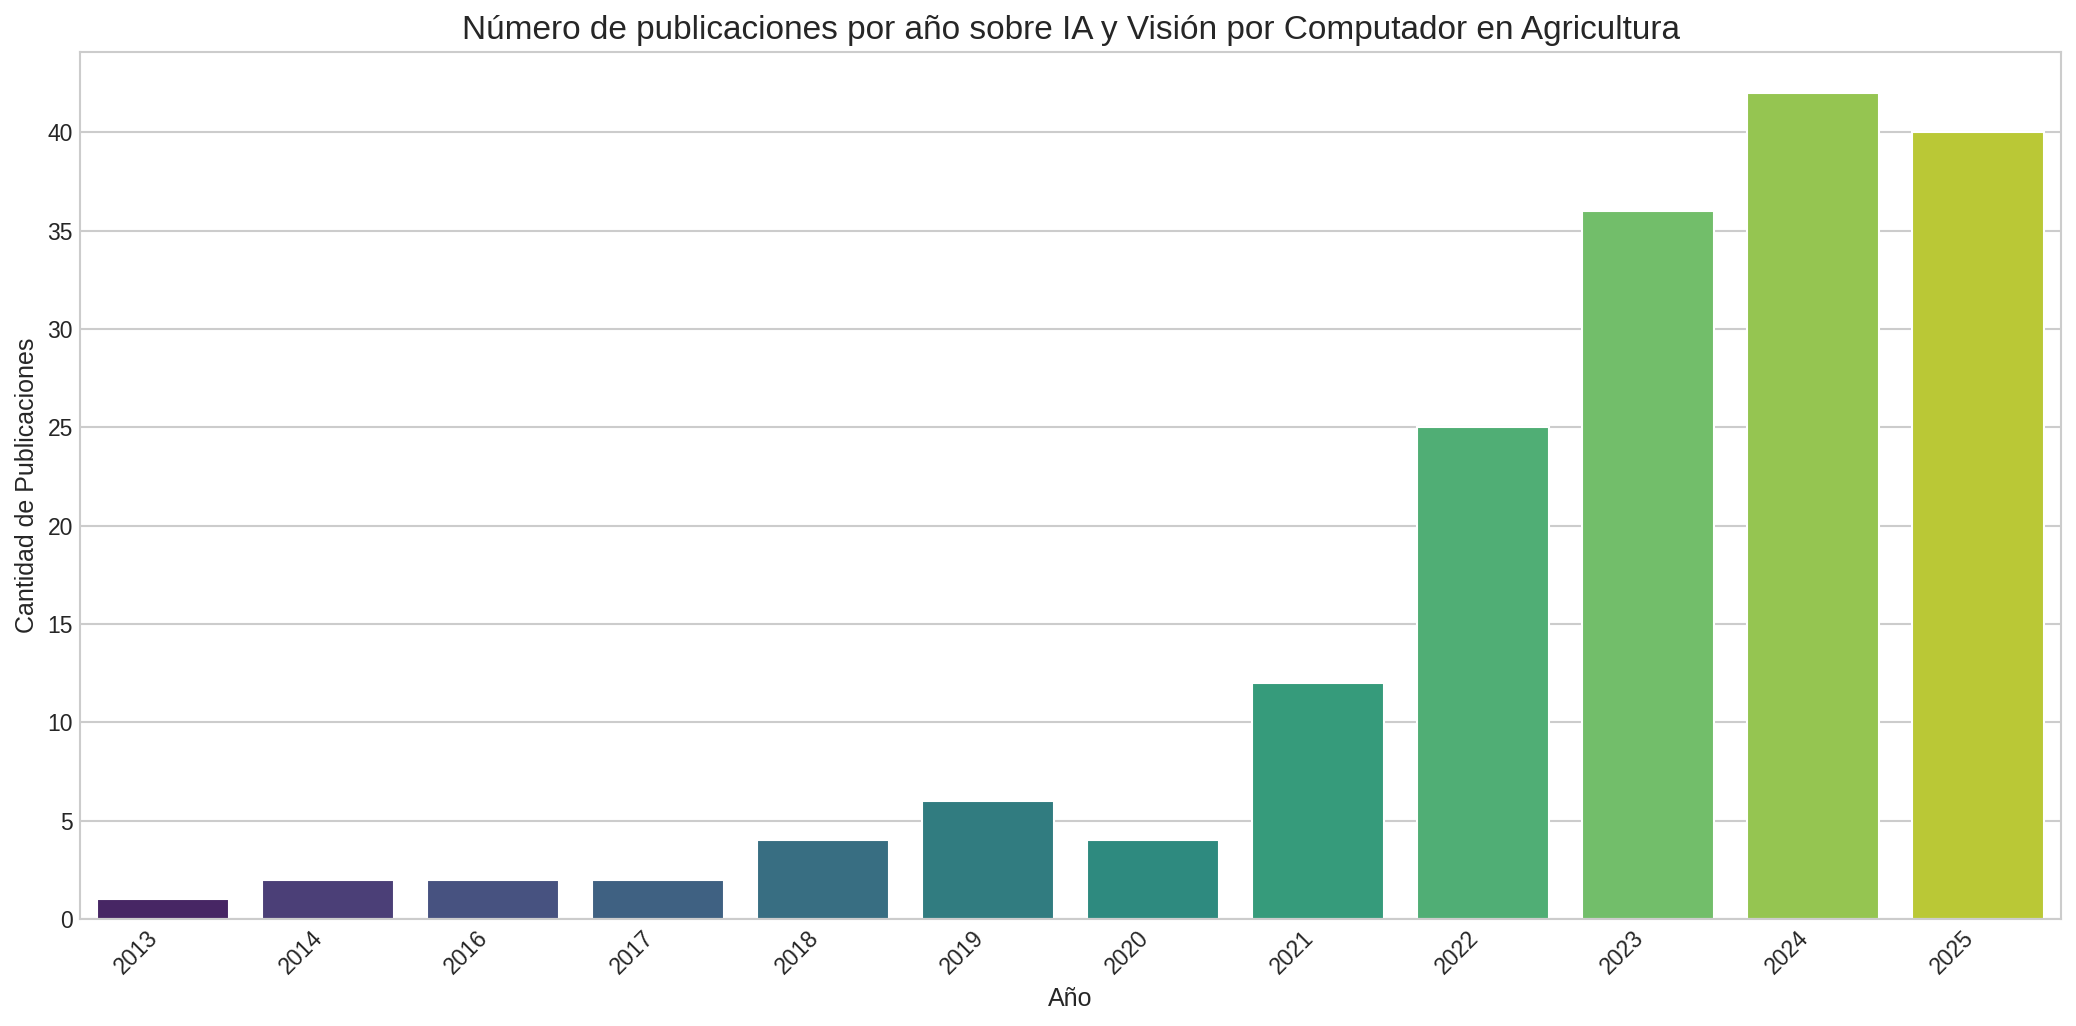

In [320]:
# Contar publicaciones por año y ordenarlas
publications_per_year = df['year'].value_counts().sort_index()

# Filtrar para mostrar desde el año 2000 para mayor claridad
publications_per_year = publications_per_year[publications_per_year.index >= 2000]

# Visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 7))
sns.barplot(x=publications_per_year.index, y=publications_per_year.values, palette="viridis")
plt.title('Número de publicaciones por año sobre IA y Visión por Computador en Agricultura', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de Publicaciones', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

/tmp/ipykernel_307540/3052633649.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_authors.values, y=top_authors.index, palette="mako_r", orient='h')


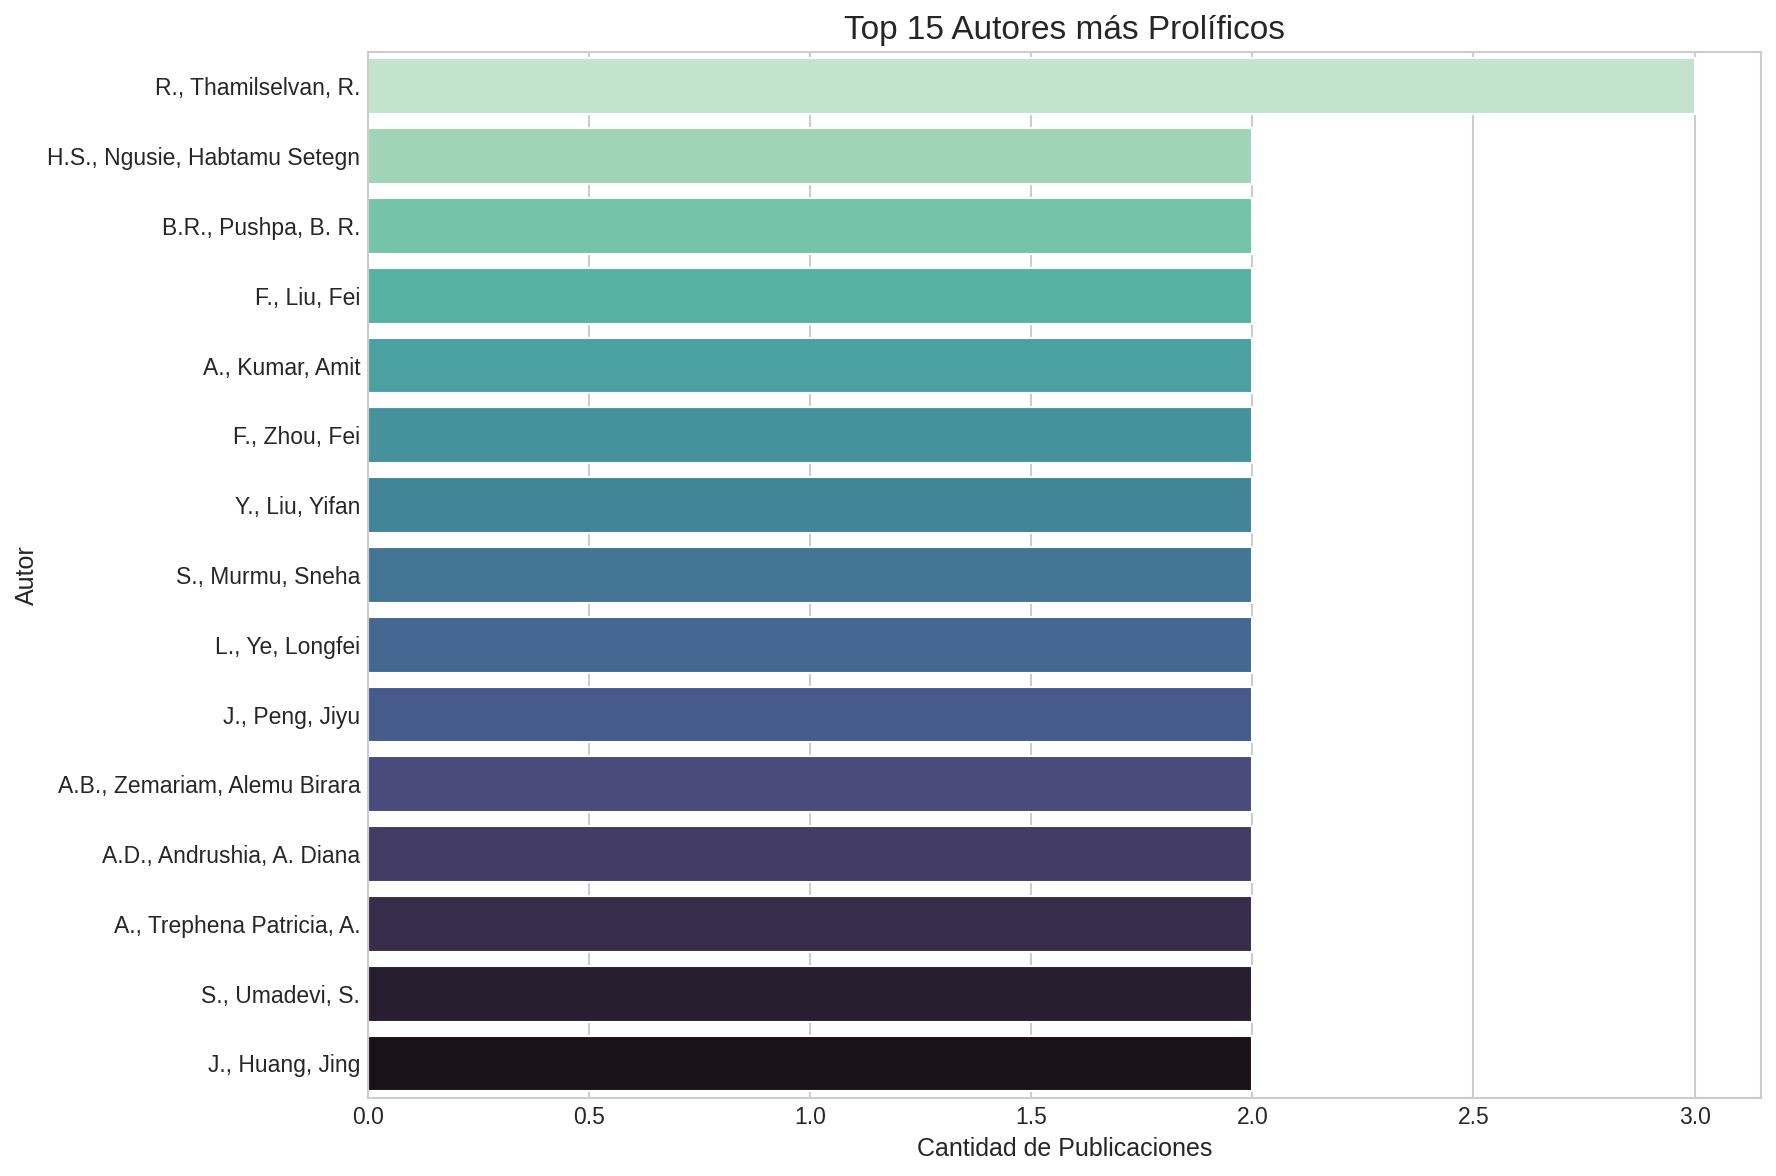

In [321]:
# Usamos 'explode' para crear una fila por cada autor en la lista 'authors_list'
authors_exploded = df.explode('authors_list')

# Contamos la frecuencia de cada autor y tomamos el top 15
top_authors = authors_exploded['authors_list'].value_counts().nlargest(15)

# Visualización
plt.figure(figsize=(12, 8))
sns.barplot(x=top_authors.values, y=top_authors.index, palette="mako_r", orient='h')
plt.title('Top 15 Autores más Prolíficos', fontsize=16)
plt.xlabel('Cantidad de Publicaciones', fontsize=12)
plt.ylabel('Autor', fontsize=12)
plt.tight_layout()
plt.show()


In [322]:
# Rellenar valores nulos en columnas clave para el análisis
df['authors'].fillna('Desconocido', inplace=True)
df['author_keywords'].fillna('', inplace=True)
df['document_type'].fillna('No especificado', inplace=True)
df['source_title'].fillna('No especificado', inplace=True)


# --- 3. Estructurar Columnas para Análisis ---
# Crear listas a partir de cadenas separadas por ';'
def split_and_clean(text, delimiter=';'):
    if not isinstance(text, str):
        return []
    return [item.strip() for item in text.split(delimiter) if item.strip()]

df['authors_list'] = df['authors'].apply(split_and_clean)
df['keywords_list'] = df['author_keywords'].apply(lambda x: [kw.lower() for kw in split_and_clean(x)])

print("\nPreparación de datos completada. ¡Listos para el EDA!")


Preparación de datos completada. ¡Listos para el EDA!


/tmp/ipykernel_307540/1145837404.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['authors'].fillna('Desconocido', inplace=True)
/tmp/ipykernel_307540/1145837404.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['authors'].fillna('Desconocido', inplace=True)
/tmp/ipykernel_307540/1145837404.py:3: FutureWarning: A value is trying to 

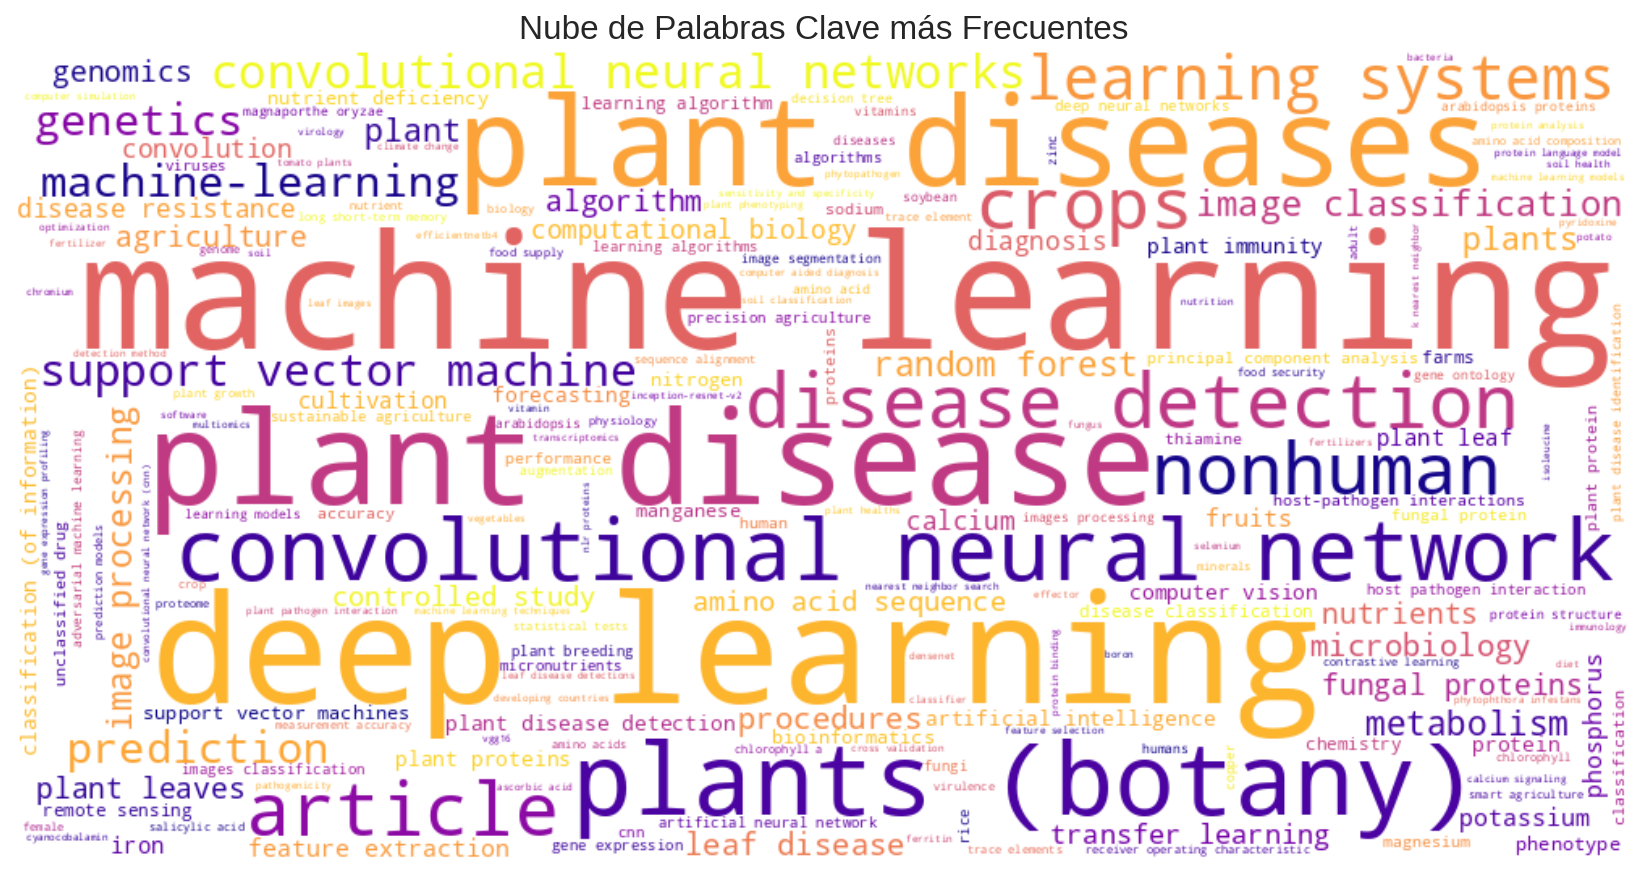

In [323]:
# Juntar todas las palabras clave en una sola lista
all_keywords = [kw for sublist in df['keywords_list'] for kw in sublist]

# Contar la frecuencia de cada palabra clave
keyword_counts = Counter(all_keywords)

# Generar la nube de palabras



wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='plasma').generate_from_frequencies(keyword_counts)

# Visualización
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras Clave más Frecuentes', fontsize=16)
plt.show()


/tmp/ipykernel_307540/2708844536.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_sources.values, y=top_sources.index, palette="rocket_r", orient='h')


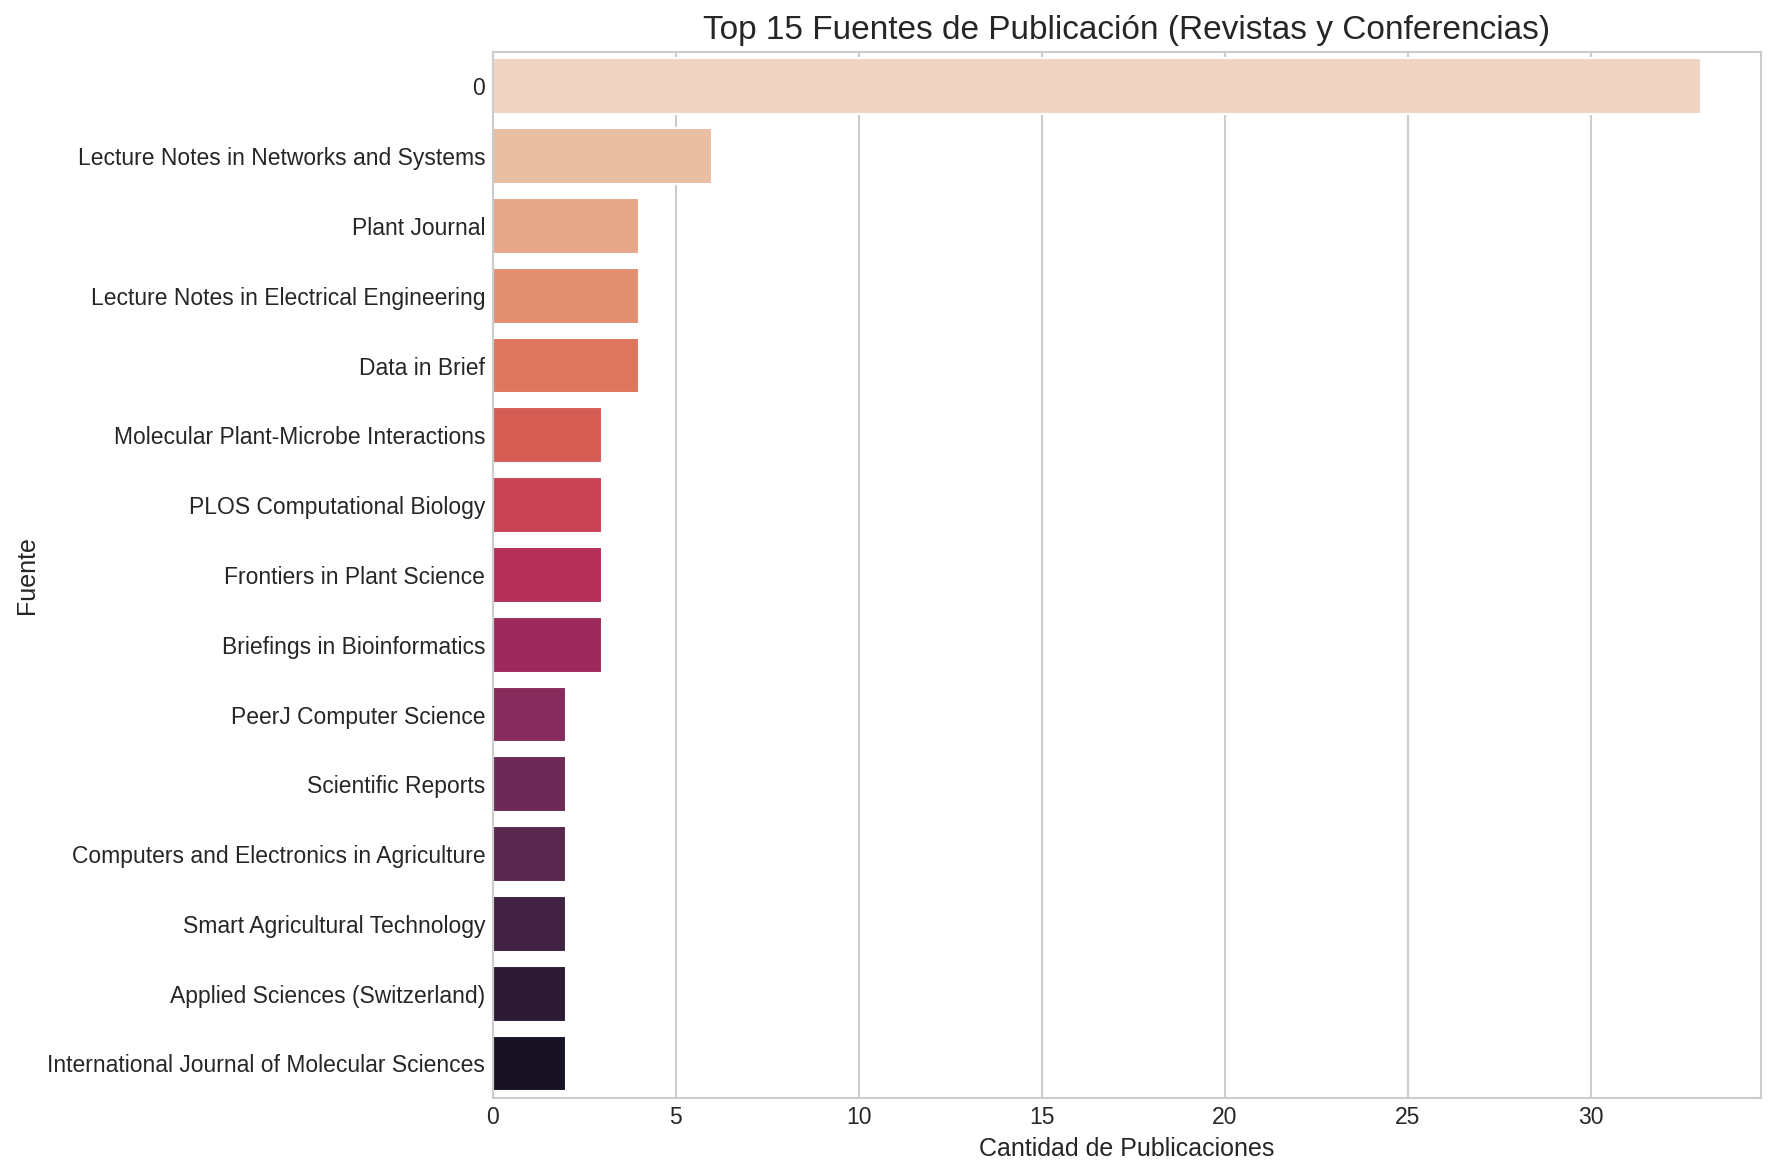

In [324]:
# Contar publicaciones por fuente y tomar el top 15
top_sources = df['source_title'].value_counts().nlargest(15)

# Visualización
plt.figure(figsize=(12, 8))
sns.barplot(x=top_sources.values, y=top_sources.index, palette="rocket_r", orient='h')
plt.title('Top 15 Fuentes de Publicación (Revistas y Conferencias)', fontsize=16)
plt.xlabel('Cantidad de Publicaciones', fontsize=12)
plt.ylabel('Fuente', fontsize=12)
plt.tight_layout()
plt.show()


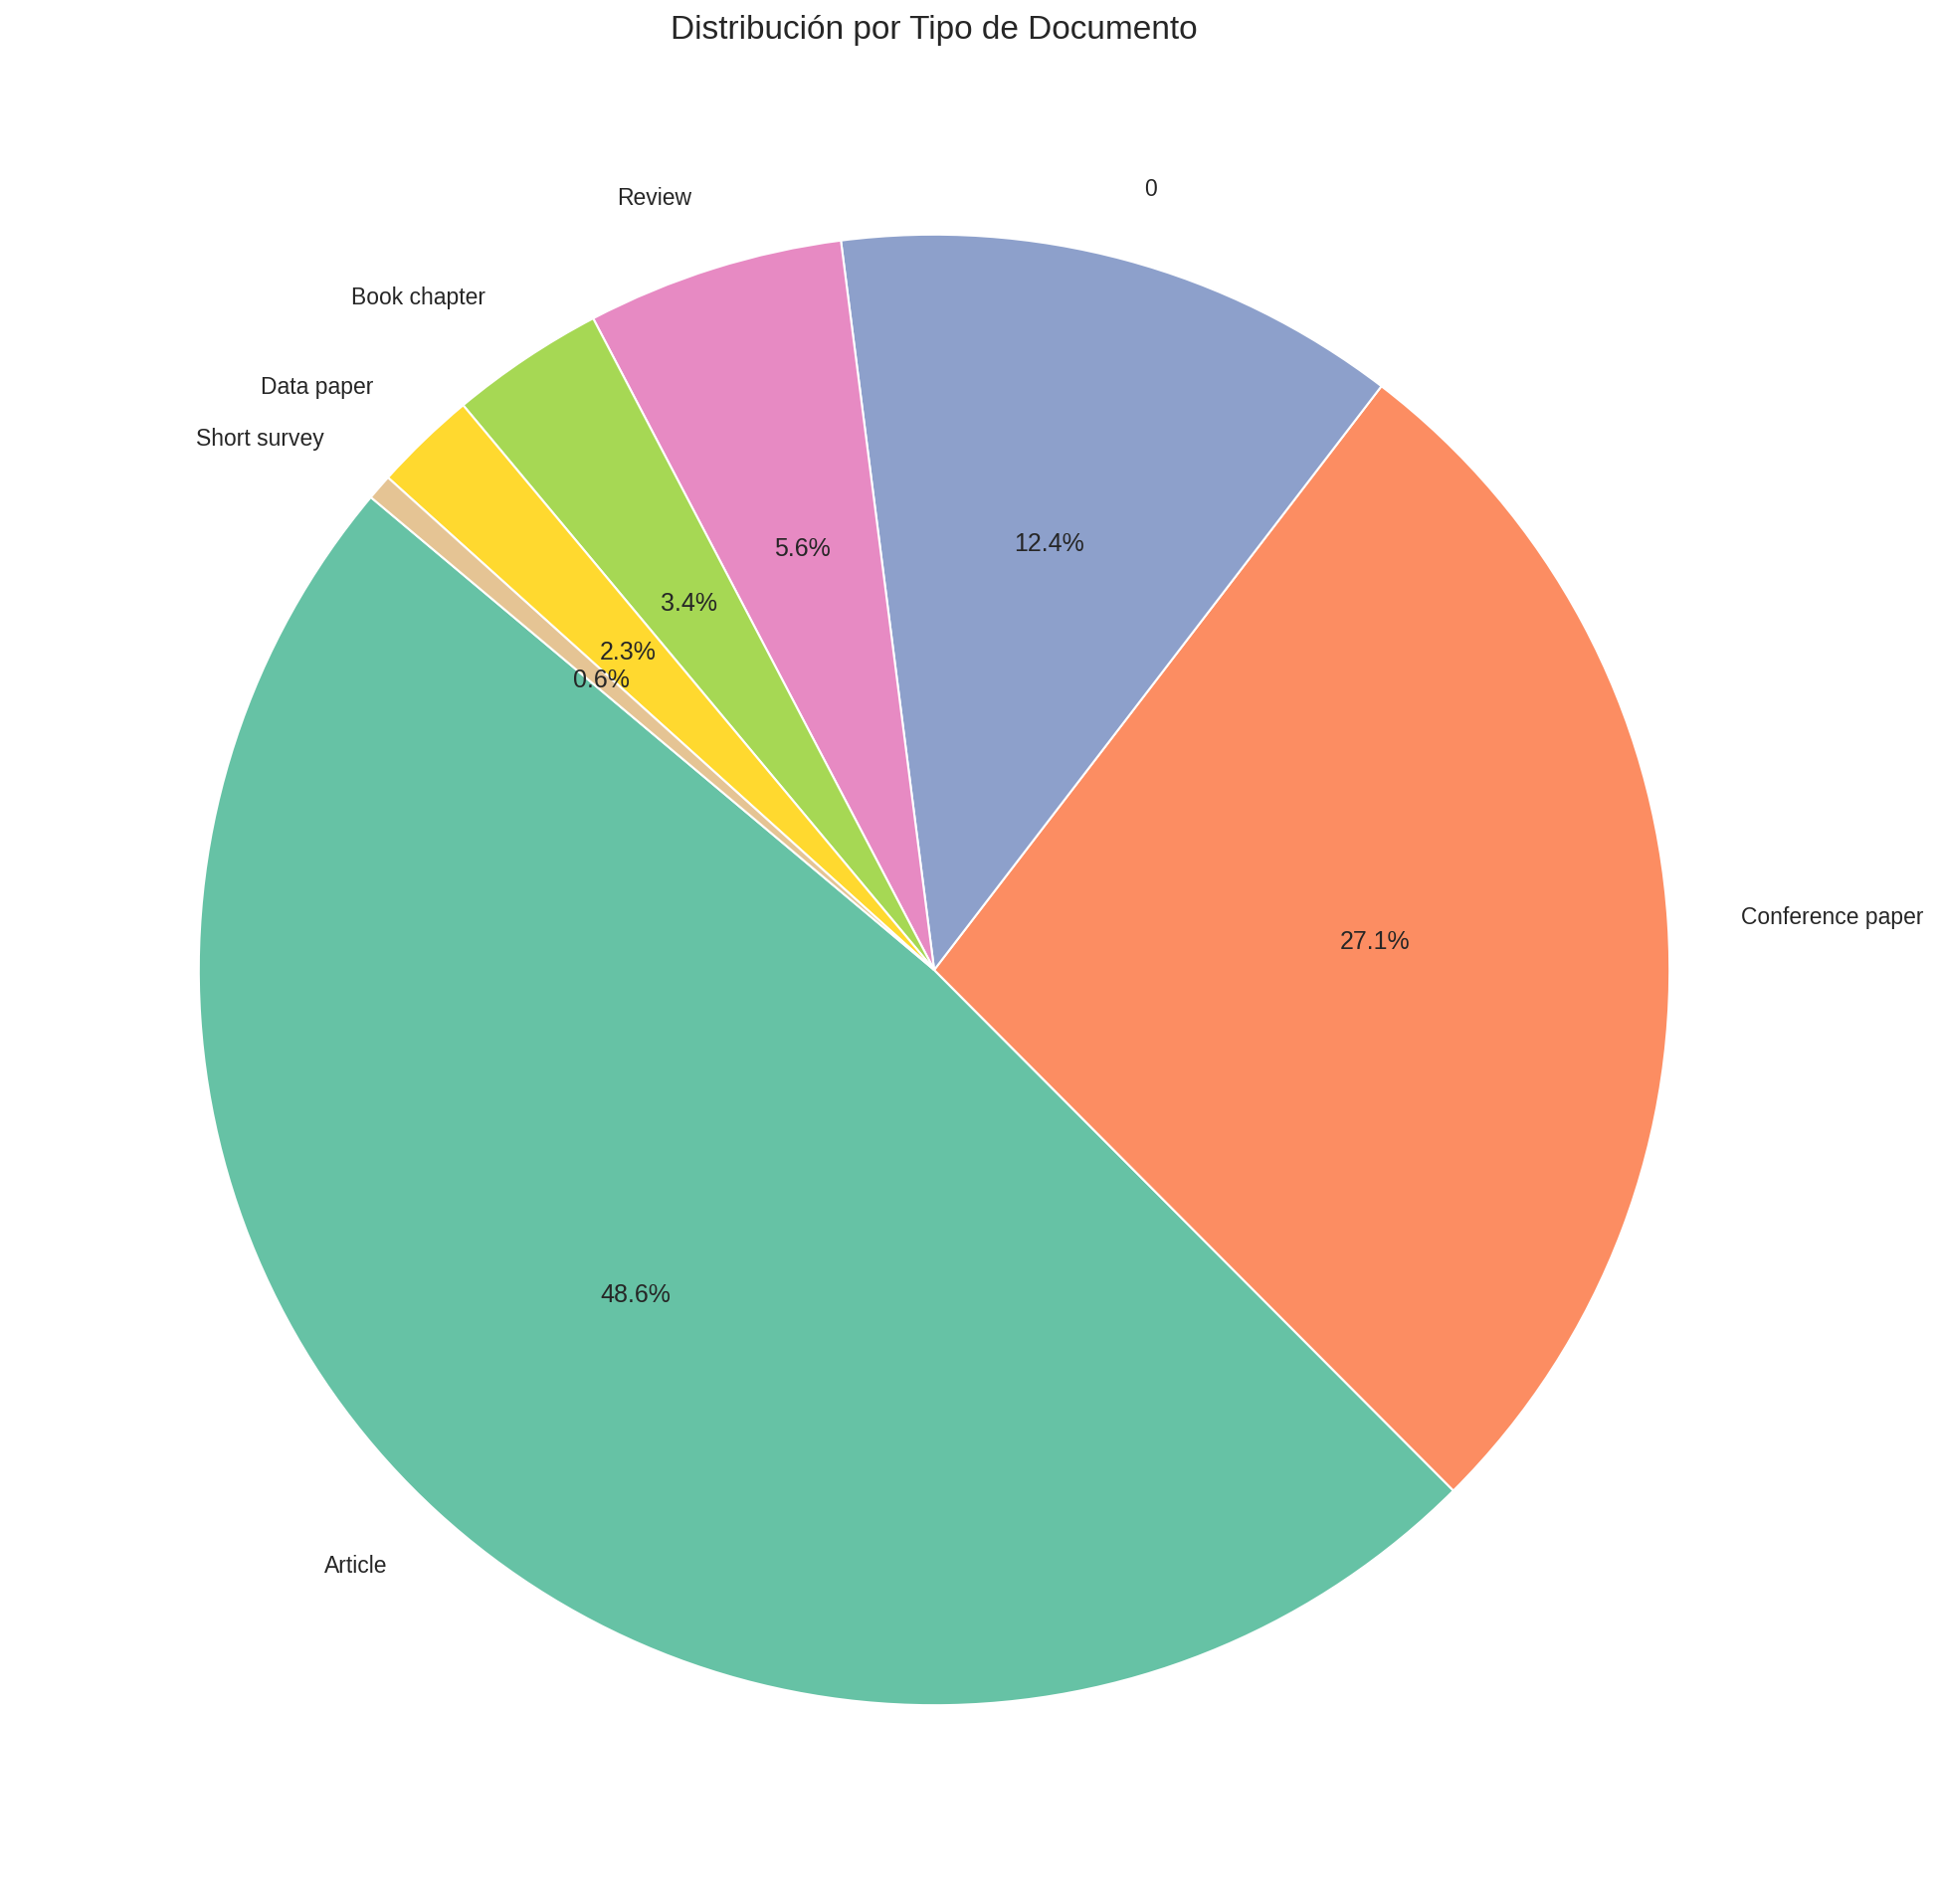

In [325]:
# Contar la frecuencia de cada tipo de documento
doc_types = df['document_type'].value_counts()

# Visualización
plt.figure(figsize=(24, 16))
plt.pie(doc_types, labels=doc_types.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
plt.title('Distribución por Tipo de Documento', fontsize=16)
plt.ylabel('') # Ocultar la etiqueta del eje y
plt.show()


In [326]:
# Lista para almacenar todas las aristas (pares de co-autores)
edge_list = []

# Iterar sobre cada lista de autores en el DataFrame
for authors in df['authors_list']:
    # Solo nos interesan las publicaciones con 2 o más autores
    if len(authors) > 1:
        # Generar todas las combinaciones de 2 autores
        # Usamos sorted() para que el par (Autor A, Autor B) sea igual a (Autor B, Autor A)
        links = combinations(sorted(authors), 2)
        edge_list.extend(links)

# Contar la frecuencia de cada colaboración (el peso de cada arista)
collaboration_counts = Counter(edge_list)

print(f"Se encontraron {len(collaboration_counts)} colaboraciones únicas.")
print("\nTop 10 colaboraciones más fuertes:")
print(collaboration_counts.most_common(10))


Se encontraron 1910 colaboraciones únicas.

Top 10 colaboraciones más fuertes:
[(('F., Liu, Fei', 'F., Zhou, Fei'), 2), (('F., Liu, Fei', 'J., Huang, Jing'), 2), (('F., Liu, Fei', 'J., Peng, Jiyu'), 2), (('F., Liu, Fei', 'L., Ye, Longfei'), 2), (('F., Liu, Fei', 'Y., Liu, Yifan'), 2), (('F., Zhou, Fei', 'J., Huang, Jing'), 2), (('F., Zhou, Fei', 'J., Peng, Jiyu'), 2), (('F., Zhou, Fei', 'L., Ye, Longfei'), 2), (('F., Zhou, Fei', 'Y., Liu, Yifan'), 2), (('J., Huang, Jing', 'J., Peng, Jiyu'), 2)]


In [327]:
# Crear un grafo vacío
G = nx.Graph()

# Añadir las aristas con su peso (número de colaboraciones)
for (author1, author2), count in collaboration_counts.items():
    G.add_edge(author1, author2, weight=count)

print(f"\nGrafo creado con {G.number_of_nodes()} nodos (autores) y {G.number_of_edges()} aristas (colaboraciones).")



Grafo creado con 752 nodos (autores) y 1910 aristas (colaboraciones).


In [328]:
# --- Filtrar para mantener solo el núcleo de la red ---
# 1. Calcular el número de publicaciones de cada autor
all_authors = [author for sublist in df['authors_list'] for author in sublist]
author_counts = Counter(all_authors)

# 2. Seleccionar los N autores más prolíficos (ej. top 50)
N_TOP_AUTHORS = 50
top_authors_list = [author for author, count in author_counts.most_common(N_TOP_AUTHORS)]

# 3. Crear un subgrafo que solo contenga a estos autores y las conexiones entre ellos
core_graph = G.subgraph(top_authors_list)

# 4. (Opcional pero recomendado) Mantener solo el componente conectado más grande para una mejor visualización
largest_cc = max(nx.connected_components(core_graph), key=len)
final_graph = core_graph.subgraph(largest_cc)

print(f"\nSubgrafo final para visualización con {final_graph.number_of_nodes()} autores y {final_graph.number_of_edges()} colaboraciones.")



Subgrafo final para visualización con 10 autores y 45 colaboraciones.


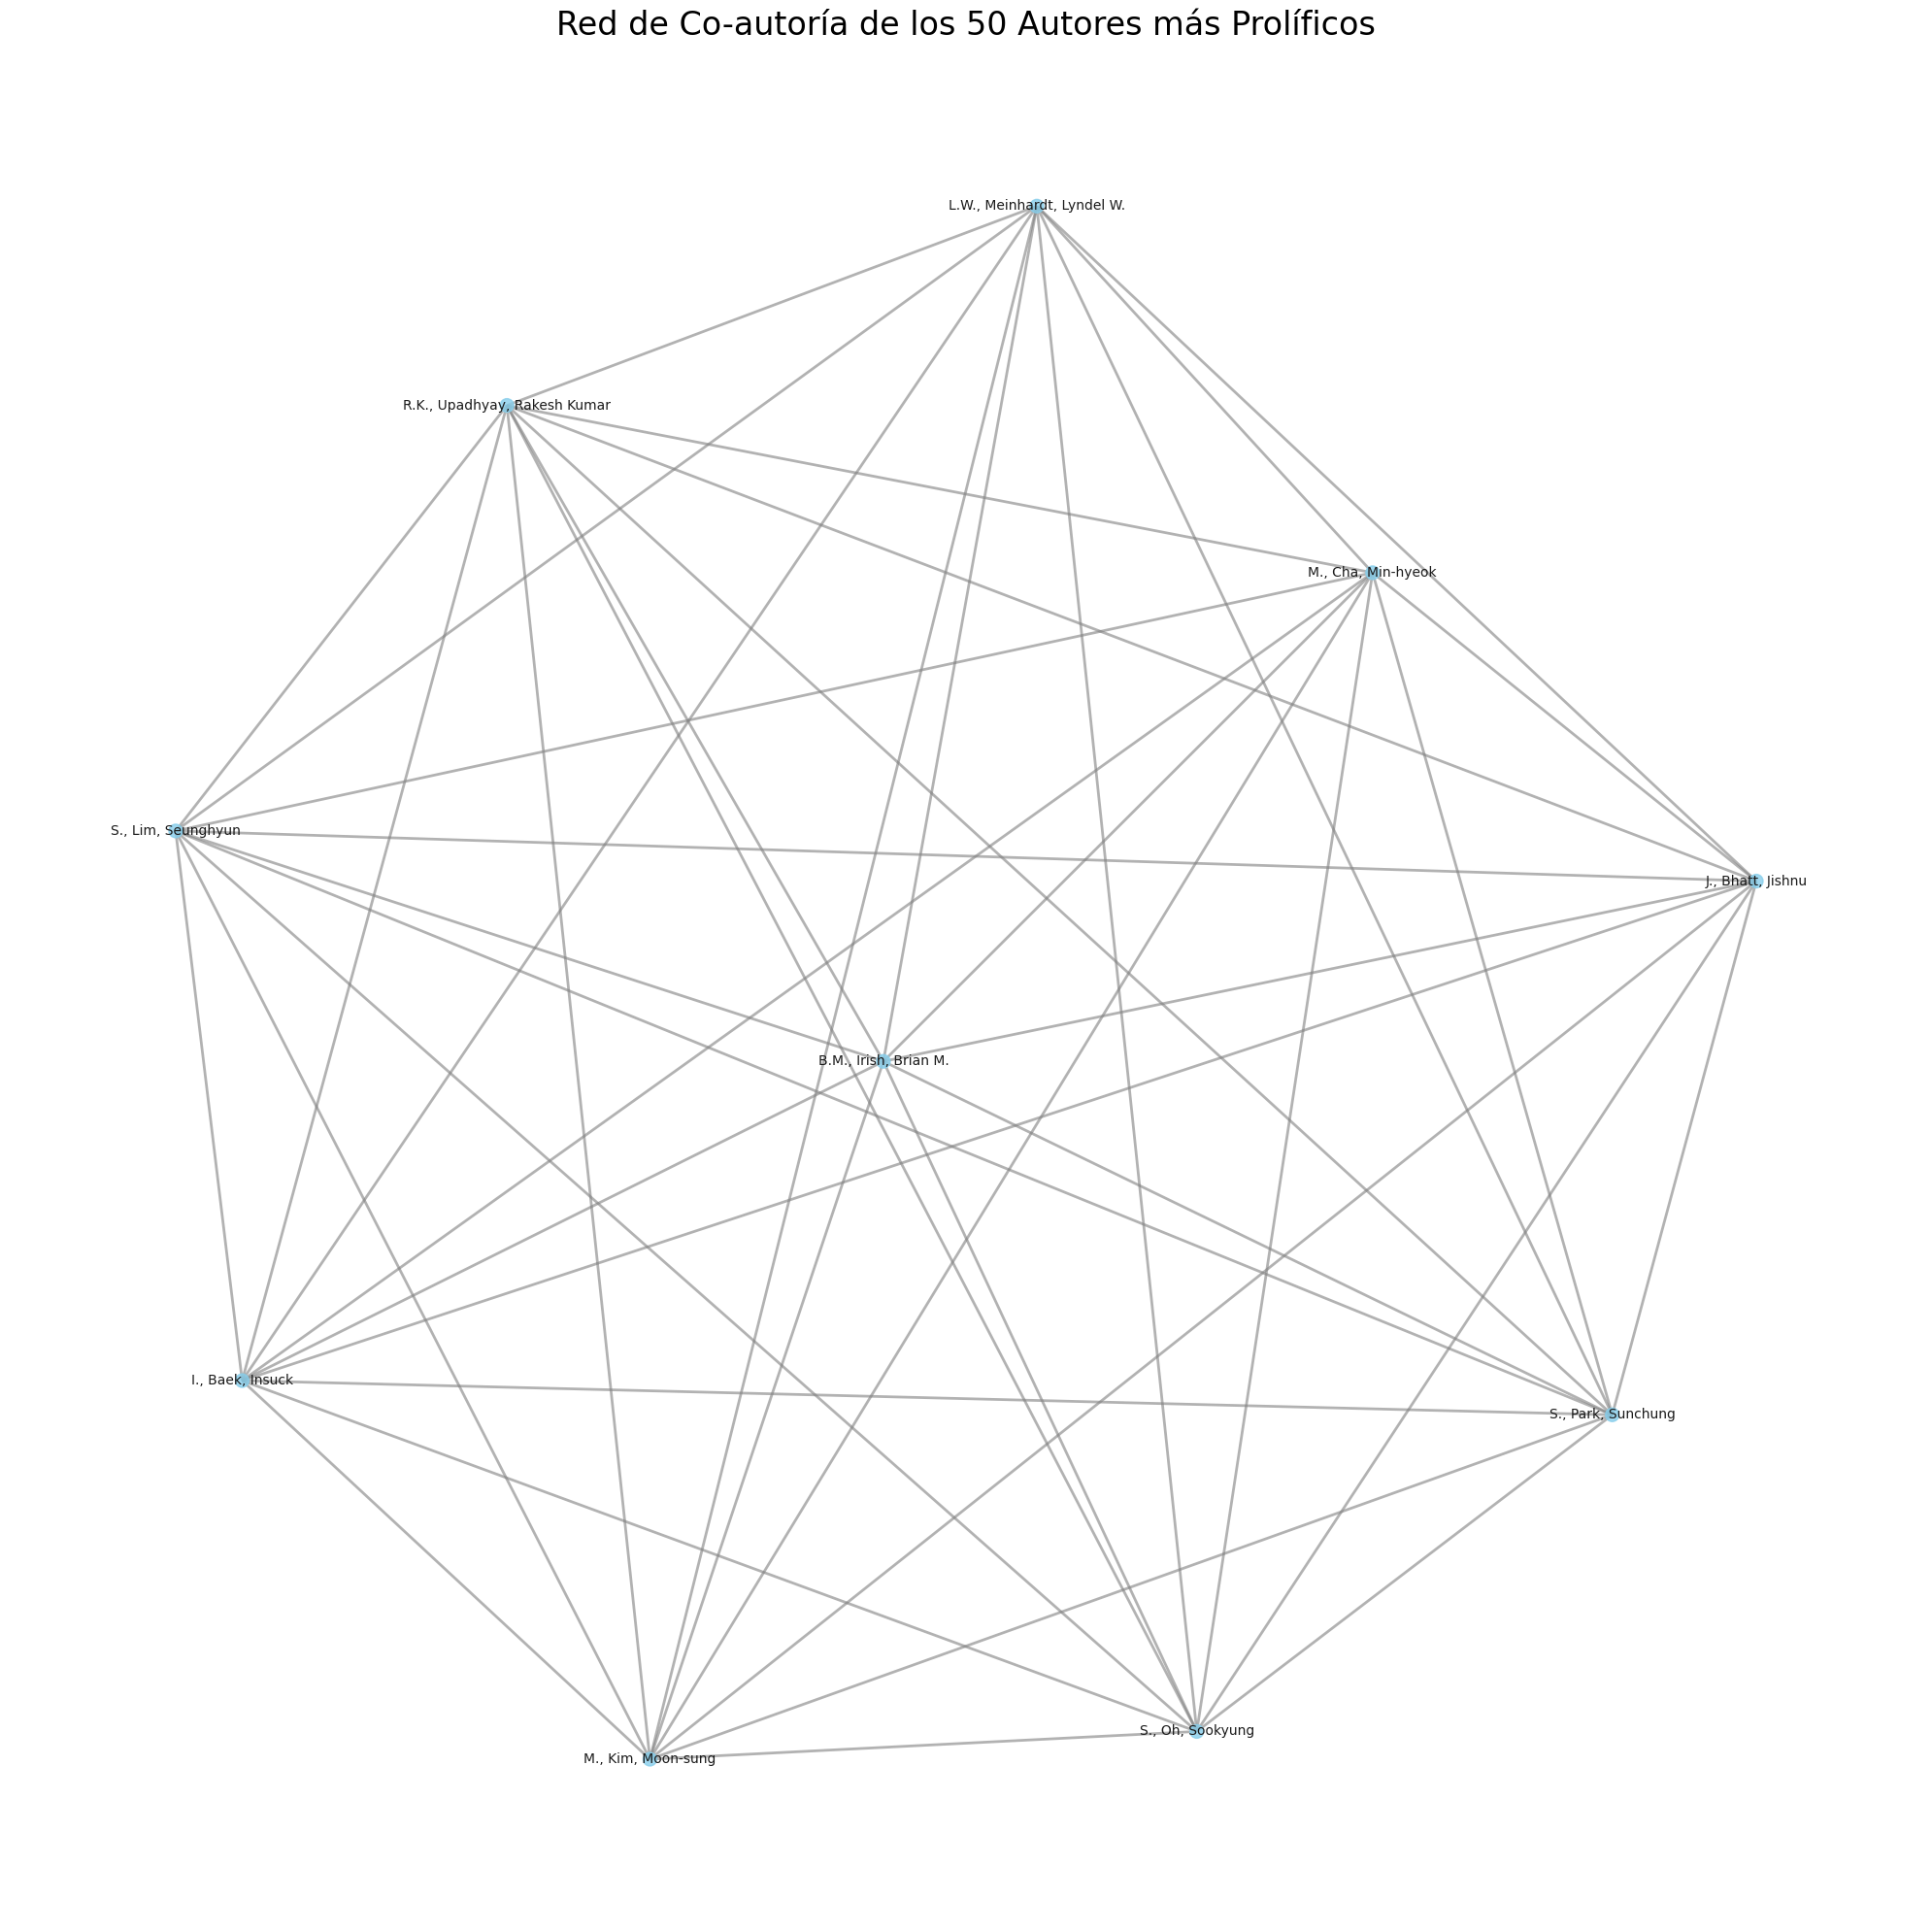

In [329]:
plt.style.use('default')
plt.figure(figsize=(20, 20))

# --- Posicionamiento de los nodos ---
# El layout "spring" simula una repulsión entre nodos y una atracción por las aristas
pos = nx.spring_layout(final_graph, k=0.6, iterations=50, seed=42)

# --- Dibujar los nodos ---
# El tamaño del nodo será proporcional a su número de publicaciones
node_sizes = [author_counts[node] * 100 for node in final_graph.nodes()]
nx.draw_networkx_nodes(final_graph, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8)

# --- Dibujar las aristas ---
# El grosor de la arista será proporcional al número de colaboraciones
edge_weights = [final_graph[u][v]['weight'] * 2 for u, v in final_graph.edges()]
nx.draw_networkx_edges(final_graph, pos, width=edge_weights, edge_color='gray', alpha=0.6)

# --- Dibujar las etiquetas (nombres de los autores) ---
nx.draw_networkx_labels(final_graph, pos, font_size=10, font_family='sans-serif')

# --- Títulos y configuración del gráfico ---
plt.title('Red de Co-autoría de los 50 Autores más Prolíficos', fontsize=24)
plt.axis('off') # Ocultar los ejes
plt.tight_layout()
plt.show()


In [330]:
# Seleccionar y combinar las columnas de texto. Rellenar nulos con ''
df['title'] = df['title'].fillna('')
df['abstract'] = df['abstract'].fillna('')
df['documents'] = df['title'] + '. ' + df['abstract']

print(f"Dataset preparado con {len(df)} documentos únicos para el análisis LDA.")
print("\nEjemplo de documento combinado:")
print(df['documents'].iloc[1])

Dataset preparado con 177 documentos únicos para el análisis LDA.

Ejemplo de documento combinado:
Integrated phenotypic analysis, predictive modeling, and identification of novel trait-associated loci in a diverse Theobroma cacao collection. Background: Cacao (Theobroma cacao L.) breeding and improvement rely on understanding germplasm diversity and trait architecture. This study characterized a cacao collection (173 accessions) evaluated in Puerto Rico, examining phenotypic diversity, trait interrelationships, and performing comparative analyses with published Trinidad and Colombia datasets. We also developed machine learning (ML) models for yield prediction and identified yield-associated SNP markers. Results: The cacao collection showed significant phenotypic variation and strong intra-collection trait correlations. Comparative analyses revealed conserved trait responses across environments, notably linking susceptibility to black pod rot in Puerto Rico with Witches' Broom Disease 

/tmp/ipykernel_307540/3083154805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'] = df['title'].fillna('')
/tmp/ipykernel_307540/3083154805.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['abstract'] = df['abstract'].fillna('')
/tmp/ipykernel_307540/3083154805.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [331]:
nltk.download('wordnet')
# --- 2. Pre-procesamiento de Texto ---

# Inicializar lemmatizer y stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Stopwords organizadas según las facetas del tesauro del proyecto
custom_stopwords = {
    # Faceta TECH: Tecnología
    'tech_terms': {
        # Términos generales de IA y ML
        'artificial', 'intelligence', 'ai', 'machine', 'learning',
        'deep', 'neural', 'network', 'cnn', 'algorithm', 'model',
        # Términos de visión por computador
        'image', 'images', 'processing', 'recognition', 'detection',
        'classification', 'segmentation', 'computer', 'vision',
        # Términos de análisis espectral
        # 'spectral', 'analysis', 'nir', 'near', 'infrared', 'hyperspectral',
        # 'imaging', 'sensor', 'sensors', 'measurement', 'measurements'
    },

    # Faceta PLANT_HEALTH: Salud de la Planta
    'plant_health_terms': {
        # Términos de enfermedades y patógenos
        'disease', 'diseases', 'pathogen', 'pathogens', 'infection',
        'infections', 'pest', 'pests', 'symptom', 'symptoms',
        # Términos de estrés y deficiencias
        'stress', 'deficiency', 'deficiencies', 'disorder', 'disorders',
        'damage', 'health', 'condition', 'conditions',
        # Términos generales de plantas
        'plant', 'plants', 'leaf', 'leaves', 'foliar', 'tissue',
        'root', 'stem', 'growth', 'development'
    },

    # Faceta PREDICTION: Predicción
    'prediction_terms': {
        # Términos de predicción y estimación
        'predict', 'prediction', 'forecast', 'forecasting', 'estimate',
        'estimation', 'assess', 'assessment', 'evaluate', 'evaluation',
        # Términos de monitoreo
        'monitor', 'monitoring', 'track', 'tracking', 'detect',
        'detection', 'identify', 'identification', 'analyze', 'analysis',
        # Términos de modelado
        'model', 'modeling', 'simulate', 'simulation', 'calculate',
        'calculation', 'measure', 'measurement'
    },

    # Faceta QUALITY: Calidad Nutricional
    'quality_terms': {
        # Términos de nutrición
        'nutritional', 'nutrition', 'nutrient', 'nutrients',
        'macronutrient', 'micronutrient', 'vitamin', 'mineral',
        # Términos de calidad
        'quality', 'property', 'properties', 'characteristic',
        'characteristics', 'parameter', 'parameters',
        # Términos de composición
        'content', 'composition', 'component', 'components',
        'level', 'levels', 'concentration', 'concentrations'
    },

    # Términos metodológicos generales
    # 'research_terms': {
    #     'study', 'research', 'paper', 'article', 'method', 'approach',
    #     'technique', 'result', 'analysis', 'using', 'based', 'propose',
    #     'investigate', 'demonstrate', 'perform', 'conduct', 'implement',
    #     'evaluate', 'validate', 'verify', 'test'
    # }
}

# Combinar todas las stopwords personalizadas en un solo conjunto
all_custom_stopwords = set()
for facet_words in custom_stopwords.values():
    all_custom_stopwords.update(facet_words)

# Actualizar el conjunto de stopwords con las personalizadas
stop_words.update(all_custom_stopwords)

def preprocess_text(text):
    # 1. Convertir a minúsculas
    text = text.lower()
    # 2. Eliminar caracteres no alfabéticos (puntuación, números, etc.)
    text = re.sub(r'[^a-z\s]', '', text)
    # 3. Tokenizar (dividir el texto en palabras)
    tokens = text.split()
    # 4. Lemmatizar y eliminar stopwords y palabras cortas
    lemmatized_tokens = [
        lemmatizer.lemmatize(token) for token in tokens 
        if token not in stop_words and len(token) > 2
    ]
    return lemmatized_tokens

# Aplicar la función de pre-procesamiento a todos los documentos
processed_docs = df['documents'].map(preprocess_text)

print("\nEjemplo de documento procesado (tokenizado y lemmatizado):")
print(processed_docs.iloc[1])

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/aalejoz25/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Ejemplo de documento procesado (tokenizado y lemmatizado):
['integrated', 'phenotypic', 'predictive', 'novel', 'traitassociated', 'locus', 'diverse', 'theobroma', 'cacao', 'collection', 'background', 'cacao', 'theobroma', 'cacao', 'breeding', 'improvement', 'rely', 'understanding', 'germplasm', 'diversity', 'trait', 'architecture', 'study', 'characterized', 'cacao', 'collection', 'accession', 'evaluated', 'puerto', 'rico', 'examining', 'phenotypic', 'diversity', 'trait', 'interrelationship', 'performing', 'comparative', 'analysis', 'published', 'trinidad', 'colombia', 'datasets', 'also', 'developed', 'model', 'yield', 'identified', 'yieldassociated', 'snp', 'marker', 'result', 'cacao', 'collection', 'showed', 'significant', 'phenotypic', 'variation', 'strong', 'intracollection', 'trait', 'correlation', 'comparative', 'analysis', 'revealed', 'conserved', 'trait', 'response', 'across', 'environment', 'notably', 'linking', 'susceptibility', 'black', 'pod', 'rot', 'puerto', 'rico', 'witch

In [332]:
# --- 3. Crear Diccionario y Corpus ---

# Crear un diccionario a partir de los documentos procesados
# El diccionario mapea cada palabra a un ID único.
dictionary = Dictionary(processed_docs)

# Filtrar palabras extremas:
# - no_below: ignora palabras que aparecen en menos de 5 documentos.
# - no_above: ignora palabras que aparecen en más del 50% de los documentos.
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Crear el corpus (Bolsa de Palabras)
# Convierte cada documento en una lista de tuplas (word_id, frequency).
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

print(f"\nDiccionario creado con {len(dictionary)} palabras únicas.")
print("Ejemplo de un documento en formato BoW (ID de palabra, frecuencia):")
print(corpus[1][:10]) # Muestra los primeros 10 pares



Diccionario creado con 776 palabras únicas.
Ejemplo de un documento en formato BoW (ID de palabra, frecuencia):
[(15, 1), (20, 1), (21, 1), (34, 1), (36, 1), (47, 1), (52, 2), (53, 1), (54, 2), (58, 1)]


In [333]:
# --- 4. Construir el Modelo LDA ---

# Definir el número de tópicos a descubrir
num_topics = 8

# Construir el modelo LDA
# passes: número de veces que el modelo itera sobre todo el corpus.
# iterations: número de iteraciones por documento.
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

print(f"\nModelo LDA entrenado con {num_topics} tópicos.")
print("\nTópicos descubiertos (palabras clave por tópico):")
for idx, topic in lda_model.print_topics(-1):
    print(f"Tópico: {idx+1} \nPalabras: {topic}\n")



Modelo LDA entrenado con 8 tópicos.

Tópicos descubiertos (palabras clave por tópico):
Tópico: 1 
Palabras: 0.024*"model" + 0.019*"nitrogen" + 0.013*"network" + 0.011*"predicting" + 0.010*"phosphorus" + 0.010*"feature" + 0.010*"factor" + 0.010*"sequence" + 0.010*"study" + 0.010*"chlorophyll"

Tópico: 2 
Palabras: 0.076*"protein" + 0.054*"effector" + 0.028*"sequence" + 0.018*"fungal" + 0.014*"interaction" + 0.014*"based" + 0.012*"approach" + 0.012*"study" + 0.012*"structure" + 0.012*"structural"

Tópico: 3 
Palabras: 0.026*"nitrogen" + 0.016*"model" + 0.015*"soil" + 0.014*"data" + 0.012*"study" + 0.012*"food" + 0.011*"algorithm" + 0.011*"status" + 0.010*"micronutrient" + 0.009*"severity"

Tópico: 4 
Palabras: 0.076*"gene" + 0.034*"bacterial" + 0.031*"target" + 0.019*"viral" + 0.019*"resistance" + 0.018*"data" + 0.016*"expression" + 0.014*"mechanism" + 0.014*"study" + 0.014*"yield"

Tópico: 5 
Palabras: 0.018*"protein" + 0.018*"approach" + 0.017*"performance" + 0.015*"feature" + 0.013*"

In [334]:
# --- 5. Visualización de los Tópicos ---

# Habilitar el formateador de pyLDAvis para notebooks (si usas uno)
pyLDAvis.enable_notebook()

# Preparar los datos para la visualización
# NOTA: El cálculo puede tardar unos minutos en datasets grandes.
vis_data = gensimvis.prepare(lda_model, corpus, dictionary, mds='mmds')

# Guardar la visualización en un archivo HTML
output_filepath = './LDA_resultados.html'
pyLDAvis.save_html(vis_data, output_filepath)

print(f"\n¡Visualización LDA guardada en '{output_filepath}'!")
print("Abre este archivo en tu navegador para explorar los tópicos de forma interactiva.")

# Mostrar la visualización directamente (si estás en un Jupyter Notebook/Lab)
vis_data


/home/aalejoz25/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(



¡Visualización LDA guardada en './LDA_resultados.html'!
Abre este archivo en tu navegador para explorar los tópicos de forma interactiva.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.080995  0.069281       1        1  26.567064
7     -0.171847  0.198886       2        1  19.502539
1      0.120306 -0.248206       3        1  12.889519
2      0.088814  0.219178       4        1  12.294591
4      0.188864 -0.074900       5        1  10.979382
0      0.203584  0.090088       6        1  10.711245
3     -0.111189 -0.228128       7        1   4.008681
6     -0.237538 -0.026198       8        1   3.046979, topic_info=           Term        Freq       Total Category  logprob  loglift
118     protein  166.000000  166.000000  Default  30.0000  30.0000
433    effector   93.000000   93.000000  Default  29.0000  29.0000
104        gene   48.000000   48.000000  Default  28.0000  28.0000
206     cassava  110.000000  110.000000  Default  27.0000  27.0000
93         crop  146.000000  146.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
304      system    3.949024   56.724914   Topic8  -4.6343   0.8263
213   different    4.283077   87.380120   Topic8  -4.5531   0.4754
51   management    3.352795   35.870753   Topic8  -4.7980   1.1209
310        used    4.189050  107.262636   Topic8  -4.5753   0.2482
93         crop    3.558802  146.165267   Topic8  -4.7384  -0.2243

[455 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1         1  0.599189  accuracy
1         2  0.104858  accuracy
1         3  0.022470  accuracy
1         4  0.104858  accuracy
1         5  0.112348  accuracy
...     ...       ...       ...
145       6  0.019386     yield
145       7  0.135704     yield
145       8  0.096931     yield
585       1  0.909336     yolov
585       2  0.050519     yolov

[1019 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 2, 3, 5, 1, 4, 7])

/tmp/ipykernel_307540/676765296.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dominant_topic'] = [get_dominant_topic(corpus[i]) for i in range(len(corpus))]


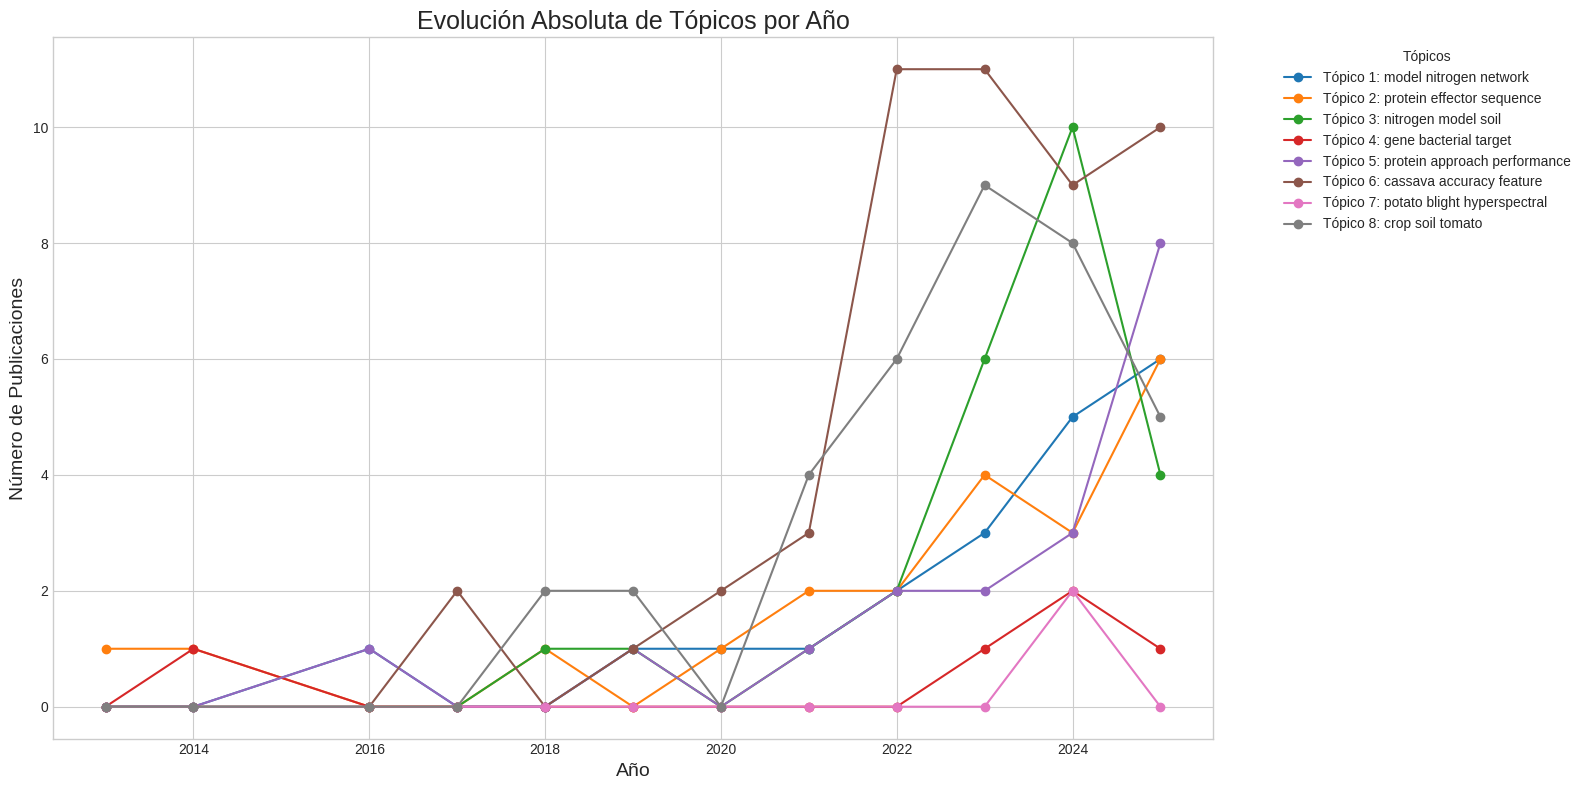

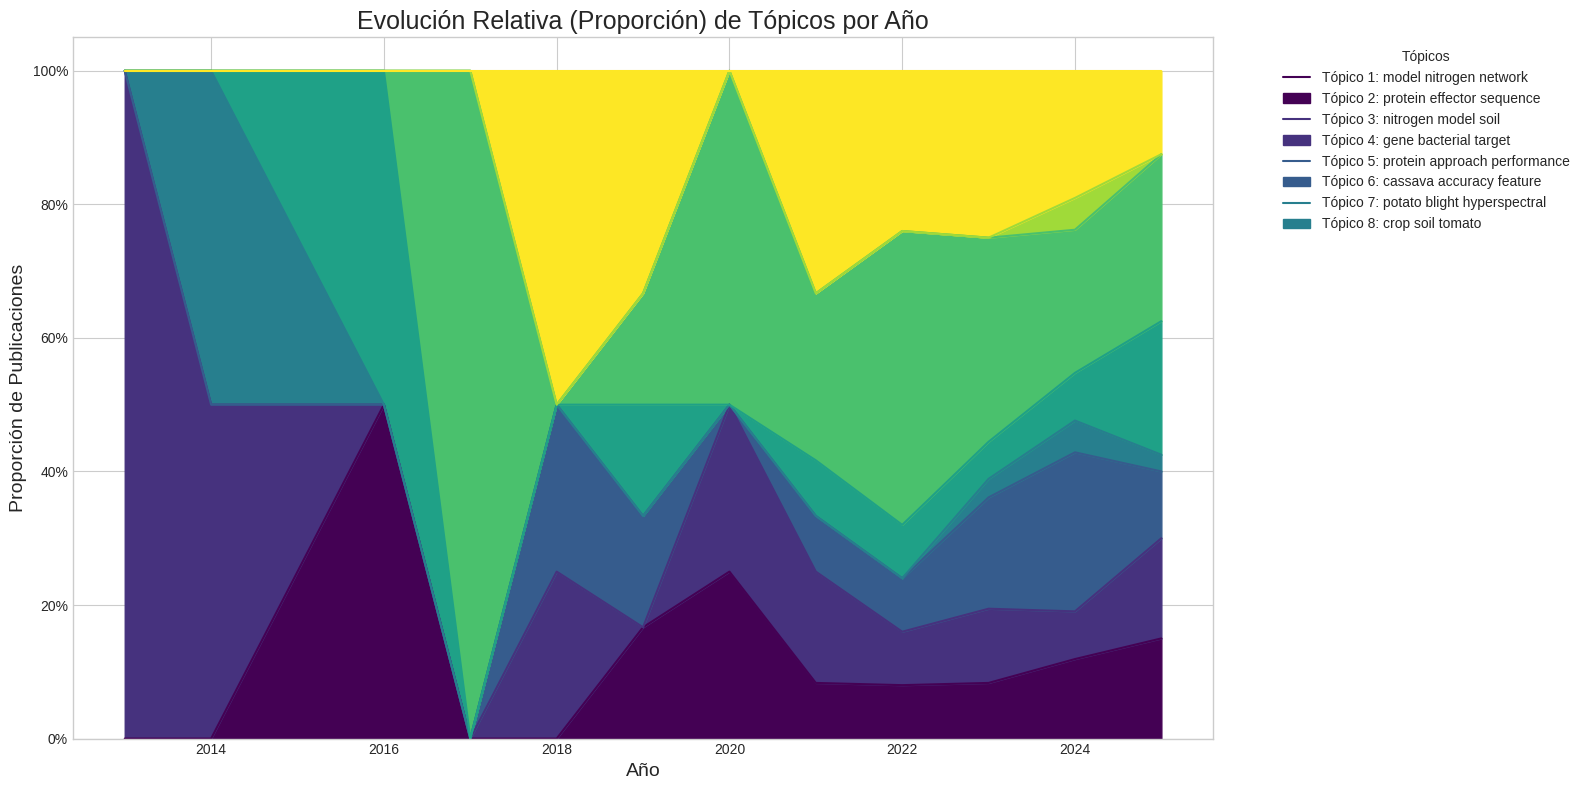

In [335]:
# --- 3. Asignar Tópico Dominante a cada Documento ---
def get_dominant_topic(bow):
    # Obtener la distribución de tópicos para un documento
    topic_distribution = lda_model.get_document_topics(bow, minimum_probability=0.0)
    # Ordenar por probabilidad y obtener el tópico con la más alta
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0]
    return dominant_topic[0]

# Crear una nueva columna en el DataFrame con el tópico dominante
# Asegurarse de que los índices coincidan después de haber eliminado filas nulas
df['dominant_topic'] = [get_dominant_topic(corpus[i]) for i in range(len(corpus))]

# --- 4. Agrupar por Año y Tópico ---
# Filtrar por un rango de años para una mejor visualización (ej. desde el 2010)
df_filtered = df[df['year'] >= 2010]

# Agrupar por año y tópico dominante, y contar el número de documentos
topic_counts_per_year = df_filtered.groupby(['year', 'dominant_topic']).size().unstack(fill_value=0)

# --- 5. Visualizar la Evolución de los Tópicos ---

# Gráfico 1: Evolución de la popularidad absoluta (número de publicaciones)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 8))
topic_counts_per_year.plot(ax=ax, marker='o', linestyle='-')

# Crear etiquetas de leyenda más descriptivas
topic_keywords = [" ".join([word for word, _ in lda_model.show_topic(i, topn=3)]) for i in range(num_topics)]
legend_labels = [f'Tópico {i+1}: {topic_keywords[i]}' for i in range(num_topics)]

ax.set_title('Evolución Absoluta de Tópicos por Año', fontsize=18)
ax.set_xlabel('Año', fontsize=14)
ax.set_ylabel('Número de Publicaciones', fontsize=14)
ax.legend(legend_labels, title='Tópicos', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Gráfico 2: Evolución de la popularidad relativa (proporción de publicaciones)
# Normalizar los datos para que cada fila sume 1 (100%)
topic_proportions = topic_counts_per_year.div(topic_counts_per_year.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(16, 8))
topic_proportions.plot(kind='area', stacked=True, ax=ax, colormap='viridis')

ax.set_title('Evolución Relativa (Proporción) de Tópicos por Año', fontsize=18)
ax.set_xlabel('Año', fontsize=14)
ax.set_ylabel('Proporción de Publicaciones', fontsize=14)
ax.legend(legend_labels, title='Tópicos', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format)) # Formatear eje Y como porcentaje
plt.tight_layout()
plt.show()

/tmp/ipykernel_307540/2209781293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keywords_list'] = df['author_keywords'].apply(split_and_clean)


Datos listos para la creación de la red de co-ocurrencia de palabras clave.

Se encontraron 53058 pares de co-ocurrencia únicos.

Top 10 co-ocurrencias más fuertes:
[(('machine learning', 'machine learning'), 54), (('machine learning', 'plant disease'), 44), (('deep learning', 'plant disease'), 43), (('machine learning', 'plant diseases'), 42), (('article', 'machine learning'), 40), (('machine learning', 'support vector machine'), 38), (('deep learning', 'deep learning'), 38), (('convolutional neural network', 'deep learning'), 37), (('deep learning', 'plants (botany)'), 36), (('machine learning', 'nonhuman'), 35)]

Grafo final para visualización con 40 nodos y 594 aristas.


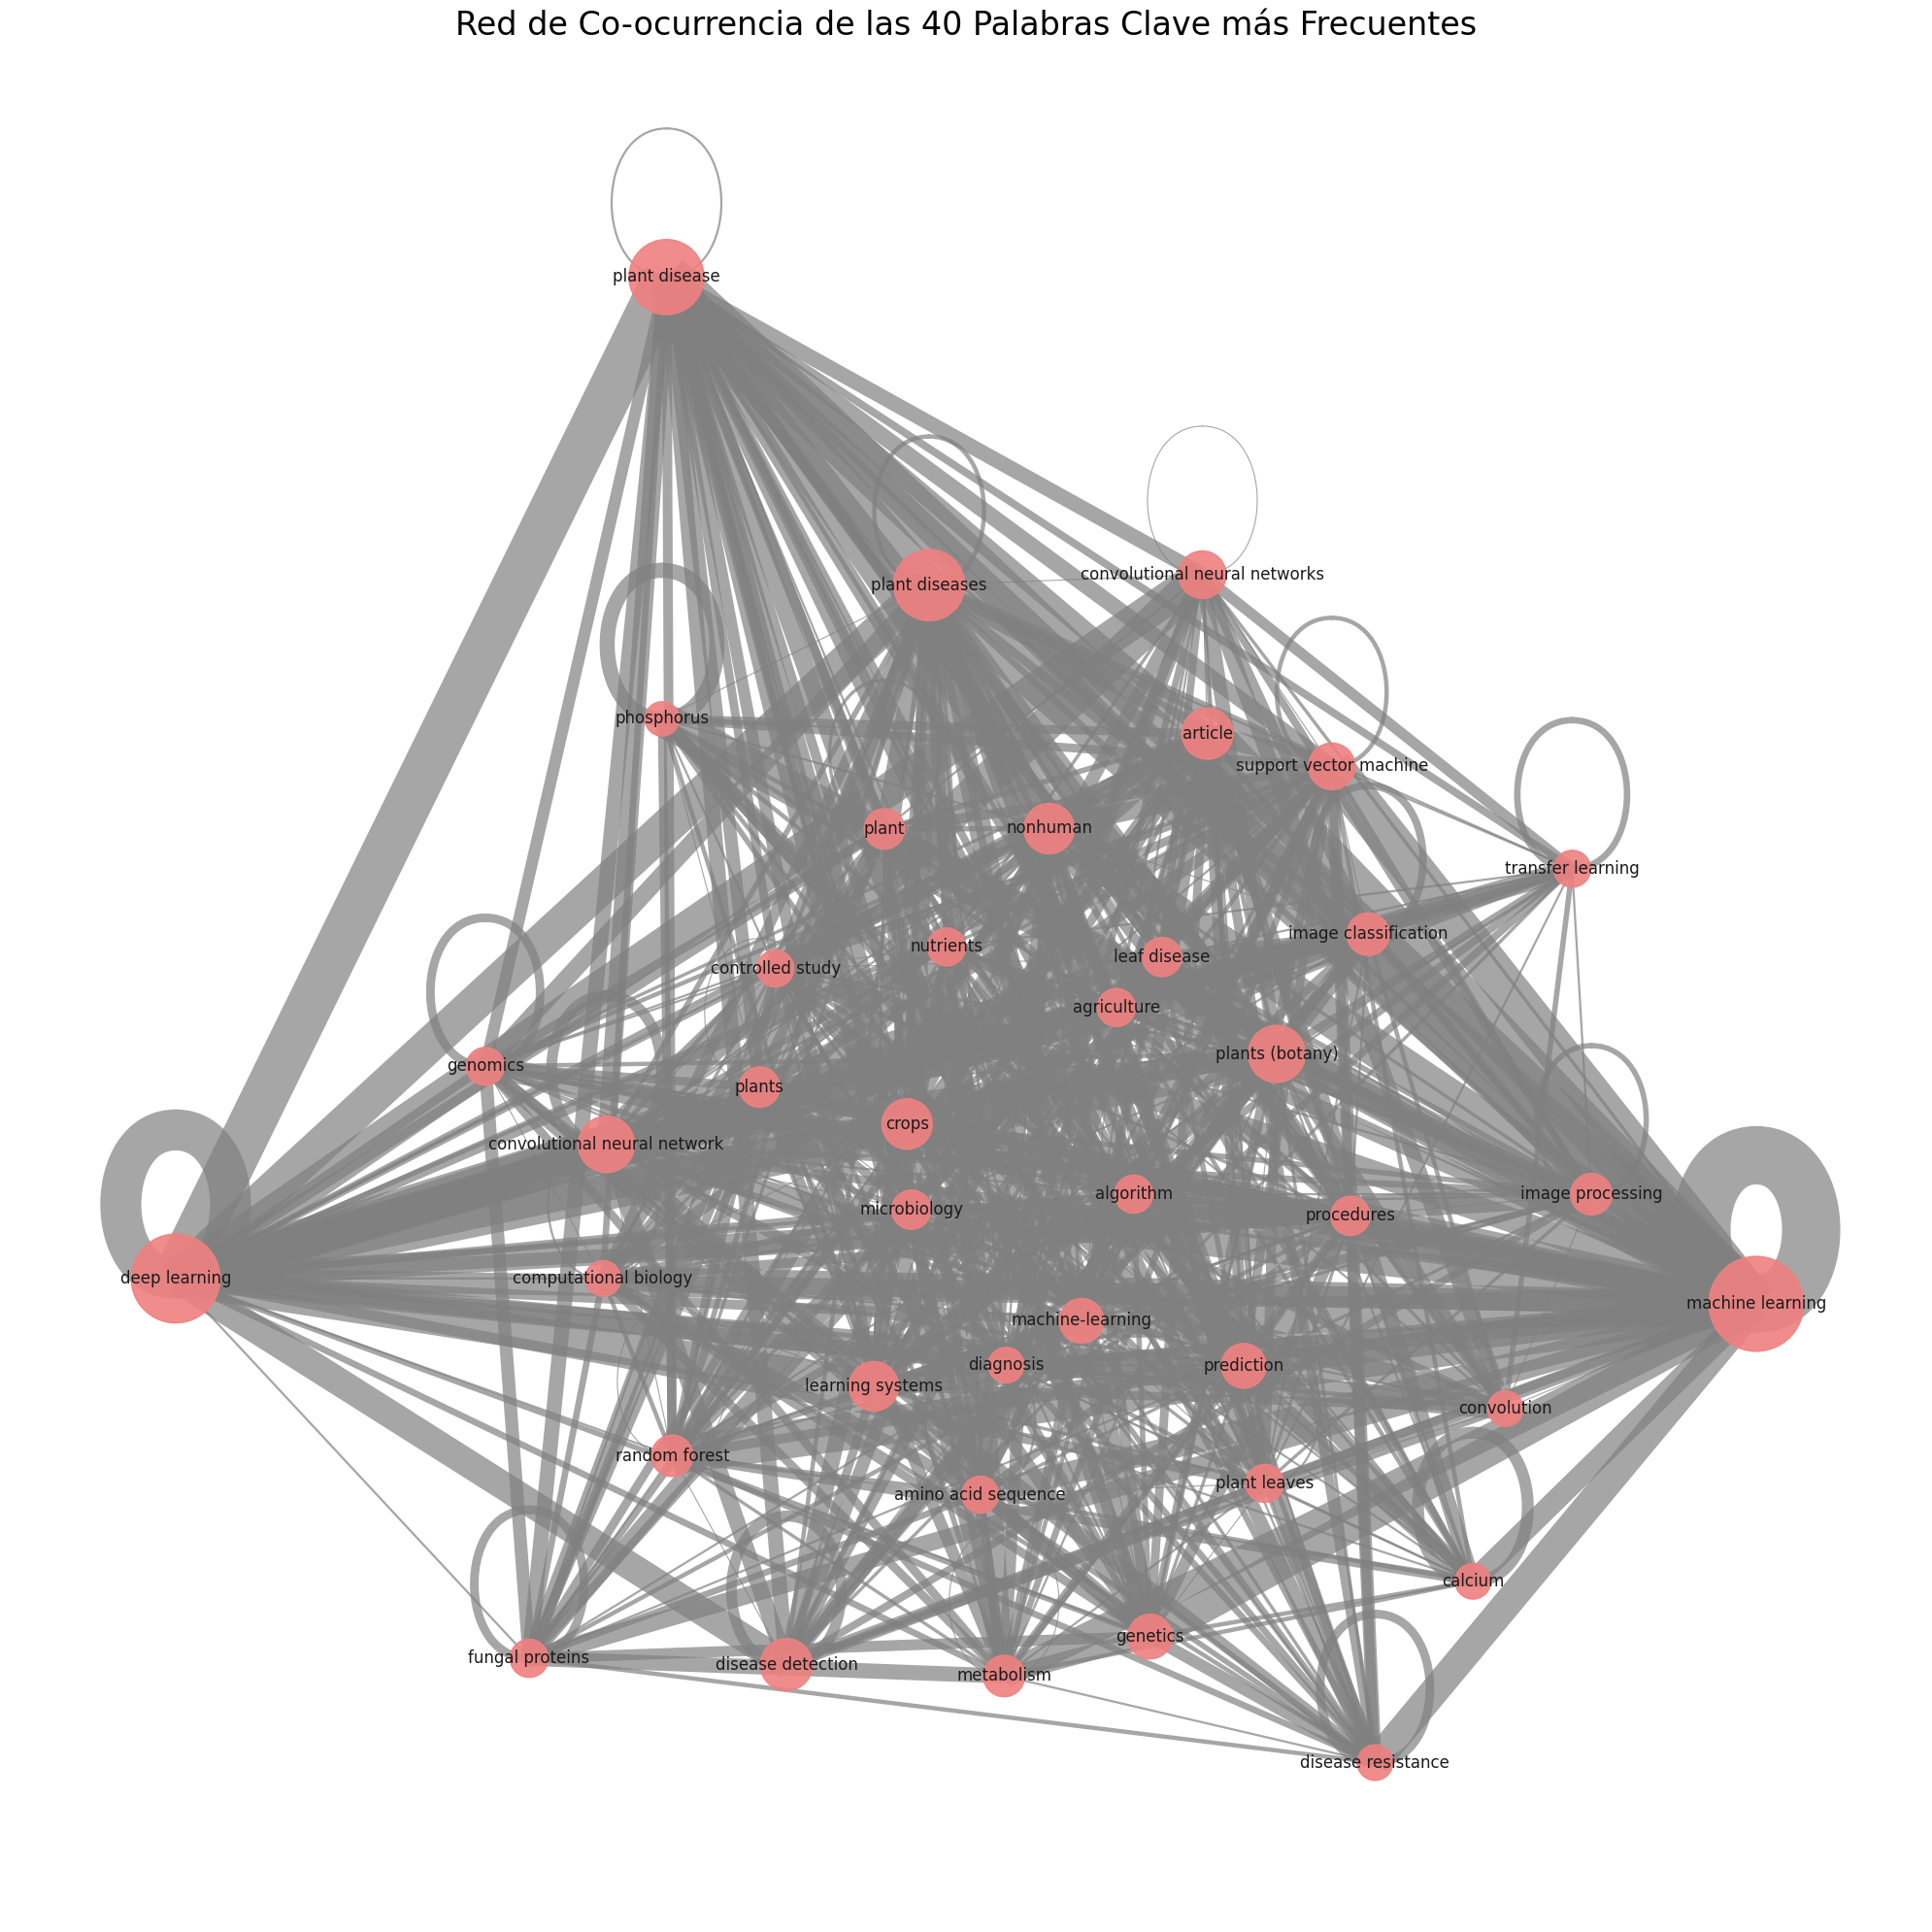

In [336]:
# --- 2. Procesamiento de Palabras Clave ---
def split_and_clean(text, delimiter=';'):
    if not isinstance(text, str):
        return []
    # Limpiamos, convertimos a minúsculas y eliminamos palabras clave genéricas
    keywords = [item.strip().lower() for item in text.split(delimiter) if item.strip()]
    # Filtramos palabras clave muy genéricas que no aportan valor a la red
    generic_kws = {'software testing', 'artificial intelligence', 'ai', 'software engineering'}
    return [kw for kw in keywords if kw not in generic_kws]

df['keywords_list'] = df['author_keywords'].apply(split_and_clean)

print("Datos listos para la creación de la red de co-ocurrencia de palabras clave.")

# --- 3. Generación de Pares de Co-ocurrencia ---
# Lista para almacenar todos los pares de palabras clave que co-ocurren
co_occurrence_pairs = []

for keywords in df['keywords_list']:
    # Solo nos interesan publicaciones con 2 o más palabras clave
    if len(keywords) > 1:
        # Generar todas las combinaciones de 2 palabras clave
        # Usamos sorted() para que el par (A, B) sea igual a (B, A)
        links = combinations(sorted(keywords), 2)
        co_occurrence_pairs.extend(links)

# Contar la frecuencia de cada par (el peso de cada arista)
pair_counts = Counter(co_occurrence_pairs)

print(f"\nSe encontraron {len(pair_counts)} pares de co-ocurrencia únicos.")
print("\nTop 10 co-ocurrencias más fuertes:")
print(pair_counts.most_common(10))

# --- 4. Filtrado y Construcción del Grafo ---
# Contar la frecuencia de cada palabra clave individualmente
all_keywords = [kw for sublist in df['keywords_list'] for kw in sublist]
keyword_counts = Counter(all_keywords)

# Seleccionar las N palabras clave más frecuentes (ej. top 40)
N_TOP_KEYWORDS = 40
top_keywords_list = [kw for kw, count in keyword_counts.most_common(N_TOP_KEYWORDS)]

# Crear el grafo
G = nx.Graph()

# Añadir nodos y aristas ponderadas para las palabras clave del top
for (kw1, kw2), weight in pair_counts.items():
    if kw1 in top_keywords_list and kw2 in top_keywords_list:
        G.add_node(kw1, size=keyword_counts[kw1])
        G.add_node(kw2, size=keyword_counts[kw2])
        G.add_edge(kw1, kw2, weight=weight)

print(f"\nGrafo final para visualización con {G.number_of_nodes()} nodos y {G.number_of_edges()} aristas.")

# --- 5. Visualización de la Red ---
plt.style.use('default')
plt.figure(figsize=(20, 20))

# Layout para posicionar los nodos
pos = nx.kamada_kawai_layout(G)

# Tamaños de los nodos proporcionales a su frecuencia
node_sizes = [data['size'] * 50 for node, data in G.nodes(data=True)]

# Grosor de las aristas proporcional a su peso (frecuencia de co-ocurrencia)
edge_widths = [d['weight'] * 0.8 for (u, v, d) in G.edges(data=True)]

# Dibujar la red
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightcoral', alpha=0.9)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='grey', alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

plt.title('Red de Co-ocurrencia de las 40 Palabras Clave más Frecuentes', fontsize=24)
plt.axis('off')
plt.tight_layout()
plt.show()

In [337]:
# --- 3. Asignar Tópico Dominante a cada Documento ---
def get_dominant_topic_for_doc(doc_bow):
    # Obtener la distribución de tópicos para un documento
    topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
    # Encontrar el tópico con la probabilidad más alta
    dominant_topic = max(topic_distribution, key=lambda x: x[1])
    return dominant_topic[0] # Devolver solo el ID del tópico

# Aplicar la función a todo el corpus para obtener el tópico dominante de cada documento
dominant_topics = [get_dominant_topic_for_doc(doc) for doc in corpus]

# Añadir la columna de tópico dominante al DataFrame
df['dominant_topic'] = dominant_topics

print("Asignación completada. Mostrando DOIs por tópico:")

# --- 4. Mostrar DOIs y Títulos para cada Tópico ---
for topic_id in range(num_topics):
    print("\n" + "="*50)
    print(f"TÓPICO #{topic_id + 1}")
    print("="*50)
    
    # Obtener y mostrar las palabras clave del tópico
    keywords = lda_model.show_topic(topic_id, topn=10)
    topic_keywords = ", ".join([word for word, prop in keywords])
    print(f"Palabras Clave: {topic_keywords}\n")
    
    # Filtrar el DataFrame para este tópico y mostrar una muestra
    topic_df = df[df['dominant_topic'] == topic_id]
    
    # Tomar una muestra de hasta 5 artículos para no saturar la salida
    sample_size = min(5, len(topic_df))
    if sample_size > 0:
        sample_articles = topic_df.sample(n=sample_size, random_state=42)
        print("Artículos de ejemplo en este tópico:")
        for index, row in sample_articles.iterrows():
            print(f"  - DOI: {row['DOI']}")
            print(f"    Título: {row['title']}")
    else:
        print("No se encontraron artículos dominantes para este tópico.")

Asignación completada. Mostrando DOIs por tópico:

TÓPICO #1
Palabras Clave: model, nitrogen, network, predicting, phosphorus, feature, factor, sequence, study, chlorophyll

Artículos de ejemplo en este tópico:
  - DOI: 10.1007/s44211-025-00814-9
    Título: Mid-FTIR and machine learning for predicting fig leaf macronutrients content
  - DOI: 10.1016/j.compag.2025.110366
    Título: Integrating Feature Selection and Machine Learning for Nitrogen Assessment in Grapevine Leaves using In-Field Hyperspectral Imaging
  - DOI: 10.1016/j.biosystemseng.2016.04.018
    Título: Machine learning based prediction of soil total nitrogen, organic carbon and moisture content by using VIS-NIR spectroscopy
  - DOI: 10.1007/s00122-025-04973-1
    Título: In silico prediction of variant effects: promises and limitations for precision plant breeding
  - DOI: 10.1016/j.scitotenv.2022.160545
    Título: Fast detection of minerals in rice leaves under chromium stress based on laser-induced breakdown spectros

/tmp/ipykernel_307540/1346653641.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dominant_topic'] = dominant_topics


/tmp/ipykernel_307540/1068742940.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=topic_distribution_counts.index, y=topic_distribution_counts.values, palette="cubehelix")
/tmp/ipykernel_307540/1068742940.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(topic_labels, rotation=0, ha="center", fontsize=10)
/tmp/ipykernel_307540/1068742940.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(topic_labels, rotation=0, ha="center", fontsize=10)


[Text(0, 0, 'Tópico 1\nmodel, nitrogen, network, predicting'),
 Text(1, 0, 'Tópico 2\nprotein, effector, sequence, fungal'),
 Text(2, 0, 'Tópico 3\nnitrogen, model, soil, data'),
 Text(3, 0, 'Tópico 4\ngene, bacterial, target, viral'),
 Text(4, 0, 'Tópico 5\nprotein, approach, performance, feature'),
 Text(5, 0, 'Tópico 6\ncassava, accuracy, feature, used'),
 Text(6, 0, 'Tópico 7\npotato, blight, hyperspectral, imaging'),
 Text(7, 0, 'Tópico 8\ncrop, soil, tomato, farmer')]

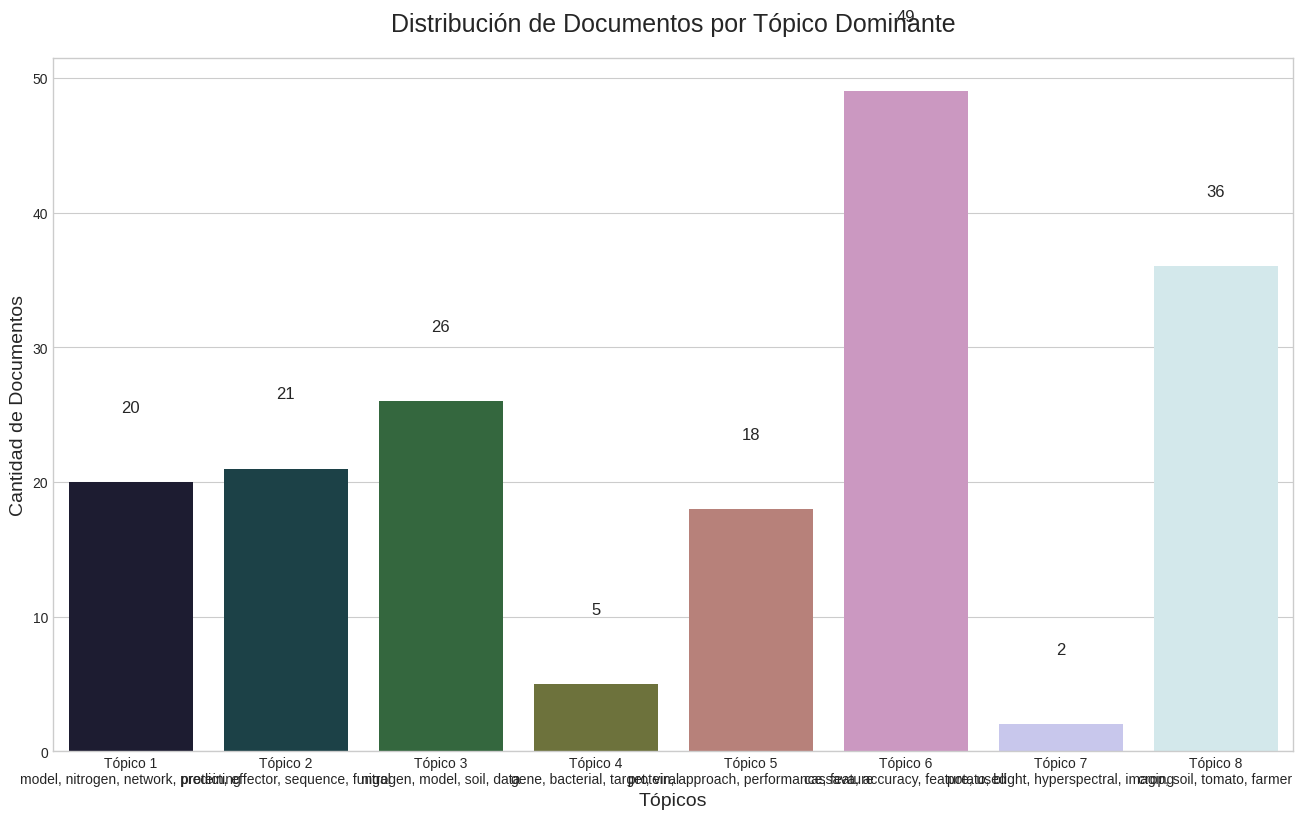

In [338]:
# --- 4. Contar Documentos por Tópico y Crear Gráfico ---

# Contar el número de documentos para cada tópico
topic_distribution_counts = df['dominant_topic'].value_counts().sort_index()

# Crear etiquetas más descriptivas para cada tópico
topic_labels = []
for i in range(num_topics):
    # Obtener las 4 palabras clave más importantes para el tópico i
    keywords = lda_model.show_topic(i, topn=4)
    # Formatear las palabras clave en una cadena
    label = f"Tópico {i+1}\n" + ", ".join([word for word, prop in keywords])
    topic_labels.append(label)

# Visualización del gráfico de barras
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 9))

ax = sns.barplot(x=topic_distribution_counts.index, y=topic_distribution_counts.values, palette="cubehelix")

# Añadir el número de documentos encima de cada barra
for index, value in enumerate(topic_distribution_counts.values):
    ax.text(index, value + 5, str(value), ha='center', va='bottom', fontsize=12)

plt.title('Distribución de Documentos por Tópico Dominante', fontsize=18, pad=20)
plt.xlabel('Tópicos', fontsize=14)
plt.ylabel('Cantidad de Documentos', fontsize=14)
ax.set_xticklabels(topic_labels, rotation=0, ha="center", fontsize=10)

In [339]:
#--- 3. Asignar Tópico Dominante y Probabilidad a cada Documento ---

def get_dominant_topic_and_prob(doc_bow):
    # Obtener la distribución de tópicos para un documento
    topic_distribution = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
    # Encontrar el tópico con la probabilidad más alta
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0]
    topic_id = dominant_topic[0]
    topic_prob = dominant_topic[1]
    return topic_id, topic_prob

# Aplicar la función a todo el corpus para obtener el tópico dominante y su probabilidad
# Usamos zip(*...) para separar las dos listas (IDs y probabilidades)
dominant_topics, topic_probabilities = zip(*[get_dominant_topic_and_prob(doc) for doc in corpus])

# --- 4. Añadir las Nuevas Columnas al DataFrame ---
df['dominant_topic'] = dominant_topics
df['topic_probability'] = topic_probabilities

print("Columnas 'dominant_topic' y 'topic_probability' añadidas.")

# --- 5. (Opcional pero recomendado) Crear una columna con etiquetas legibles ---
# Crear un diccionario para mapear el ID del tópico a un nombre descriptivo
topic_labels = {}
for i in range(num_topics):
    # Tomar las 3 palabras clave más importantes para el tópico i
    keywords = lda_model.show_topic(i, topn=3)
    # Formatear las palabras clave en una cadena legible
    label = f"Tópico {i+1}: " + ", ".join([word for word, prop in keywords])
    topic_labels[i] = label

# Mapear los IDs a las etiquetas legibles
df['topic_label'] = df['dominant_topic'].map(topic_labels)
print("Columna 'topic_label' con nombres descriptivos añadida.")


# --- 6. Mostrar el resultado ---
print("\n--- Vista previa del DataFrame con las nuevas columnas ---")
# Mostramos las columnas relevantes para verificar el resultado
print(df[['title', 'dominant_topic', 'topic_probability', 'topic_label']].head(10))

# También puedes ver la distribución de documentos por tópico
print("\n--- Distribución de documentos por tópico ---")
print(df['topic_label'].value_counts())

Columnas 'dominant_topic' y 'topic_probability' añadidas.
Columna 'topic_label' con nombres descriptivos añadida.

--- Vista previa del DataFrame con las nuevas columnas ---
                                               title  dominant_topic  \
0  Discovery of antimicrobial peptides from Bacil...               1   
1  Integrated phenotypic analysis, predictive mod...               2   
2  Mid-FTIR and machine learning for predicting f...               0   
3  Gaussian regressed generative adversarial netw...               5   
4  In silico prediction of variant effects: promi...               0   
5  PlantPathoPPI: An Ensemble-based Machine Learn...               4   
6  Monochromatic LeafAdaptNet (MLAN): an adaptive...               5   
7  Integrating multi-omics and machine learning f...               3   
8  Cauliflower leaf diseases: A computer vision d...               5   
9  Revolutionizing in vitro cultivation: machine ...               7   

   topic_probability             

/tmp/ipykernel_307540/1558733767.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dominant_topic'] = dominant_topics
/tmp/ipykernel_307540/1558733767.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic_probability'] = topic_probabilities
/tmp/ipykernel_307540/1558733767.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [340]:
# --- 4. Exportar el DataFrame a CSV y XLSX ---

# Opción 1: Exportar a CSV
# Es rápido y bueno para la compatibilidad. Usaremos '|' como separador.
csv_output_path = './referencias_con_topicos.csv'
try:
    df.to_csv(csv_output_path, sep='|', index=False, encoding='utf-8')
    print(f"\n¡Éxito! DataFrame exportado a CSV en: {csv_output_path}")
except Exception as e:
    print(f"\nOcurrió un error al guardar en CSV: {e}")


# Opción 2: Exportar a Excel (XLSX)
# Es más amigable para visualizar, pero puede generar archivos grandes.
# Nota: Necesitarás instalar la librería openpyxl: pip install openpyxl
xlsx_output_path = './referencias_con_topicos.xlsx'
try:
    # Para evitar archivos muy grandes, es buena idea seleccionar las columnas más importantes.
    # Si quieres todas las columnas, simplemente usa df.to_excel(...)
    columns_to_export = [
        'DOI', 'title', 'authors', 'year', 'source_title', 
        'dominant_topic', 'topic_probability', 'topic_label', 'abstract'
    ]
    
    df_to_export = df[columns_to_export]
    df_to_export.to_excel(xlsx_output_path, index=False, engine='openpyxl')
    print(f"¡Éxito! DataFrame exportado a Excel en: {xlsx_output_path}")
except ImportError:
    print("\nPara exportar a Excel, por favor instala la librería 'openpyxl' ejecutando: pip install openpyxl")
except Exception as e:
    print(f"\nOcurrió un error al guardar en Excel: {e}")


¡Éxito! DataFrame exportado a CSV en: ./referencias_con_topicos.csv
¡Éxito! DataFrame exportado a Excel en: ./referencias_con_topicos.xlsx
¡Éxito! DataFrame exportado a Excel en: ./referencias_con_topicos.xlsx


# Analisis descriptivo y bibliometrico

In [341]:
# validaciones 
sns.set(style="whitegrid", rc={"figure.dpi":150})

# Asegurar columnas mínimas (si faltan, crearlas vacías para evitar errores)
for c in ["fuente","authors","author_full_names","title","year","source_title","cited_by",
          "DOI","abstract","author_Keywords","index_keywords","document_type","open_access"]:
    if c not in df.columns:
        df[c] = np.nan

# info rápida
print("Registros:", df.shape[0])

Registros: 177


/tmp/ipykernel_307540/3384233130.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = np.nan


In [342]:
df[["title","year","source_title"]].head(5)

title  year  \
0  Discovery of antimicrobial peptides from Bacil...  2025   
1  Integrated phenotypic analysis, predictive mod...  2025   
2  Mid-FTIR and machine learning for predicting f...  2025   
3  Gaussian regressed generative adversarial netw...  2025   
4  In silico prediction of variant effects: promi...  2025   

                                        source_title  
0  Chemical and Biological Technologies in Agricu...  
1                                  BMC Plant Biology  
2                                Analytical Sciences  
3           Biomedical Signal Processing and Control  
4                   Theoretical and Applied Genetics

In [343]:
print(df.isnull().sum().sort_values(ascending=False).head(20))

author_Keywords           177
document_type               0
open_access                 0
source                      0
EID                         0
title_cleaned               0
abstract_cleaned            0
index_keywords_cleaned      0
authors_list                0
author_full_names_list      0
author_keywords_list        0
index_keywords_list         0
keywords_list               0
documents                   0
dominant_topic              0
topic_probability           0
topic_label                 0
publication_stage           0
fuente                      0
authors                     0
dtype: int64


In [344]:
# calidad de metadatos
# Un resumen rápido
print(df.describe(include='all').T[['count','unique']].head(30))

                        count unique
fuente                    177      3
authors                   177    177
author_full_names       177.0  156.0
author_id               177.0    NaN
title                     177    177
year                    177.0    NaN
source_title            177.0  105.0
volume                  177.0   80.0
issue                   177.0   23.0
art                     177.0    NaN
page_start              177.0   66.0
page_end                177.0    NaN
page_count              177.0    NaN
cited_by                177.0    NaN
DOI                       177    177
link                      177    177
abstract                  177    177
author_keywords         177.0  155.0
index_keywords            177    128
document_type             177      7
publication_stage         177      3
open_access             177.0   12.0
source                    177      2
EID                     177.0  156.0
title_cleaned             177    177
abstract_cleaned          177    177
i

In [345]:
# % de registros con DOI/abstract/keywords
for col in ["DOI","abstract","author_Keywords","author_full_names"]:
    pct = df[col].notna().sum()/len(df)*100
    print(f"{col}: {df[col].notna().sum()} ({pct:.1f}%)")

DOI: 177 (100.0%)
abstract: 177 (100.0%)
author_Keywords: 0 (0.0%)
author_full_names: 177 (100.0%)


In [346]:
#fuente
# Preferir 'source_title' si está, sino 'fuente'
src_col = "source_title" if "source_title" in df.columns else "fuente"
top_sources = df[src_col].fillna("Unknown").value_counts().head(30)
top_sources.to_csv("top_sources.csv")

# Índice de concentración (HHI: suma de cuadrados de shares, entre 0 y 1)
shares = df[src_col].value_counts(normalize=True)
hhi = (shares**2).sum()
print("HHI (0-1):", hhi)

HHI (0-1): 0.0433783395575984


/tmp/ipykernel_307540/1564415411.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='ngram', x='freq', data=ngram_df, palette='mako')


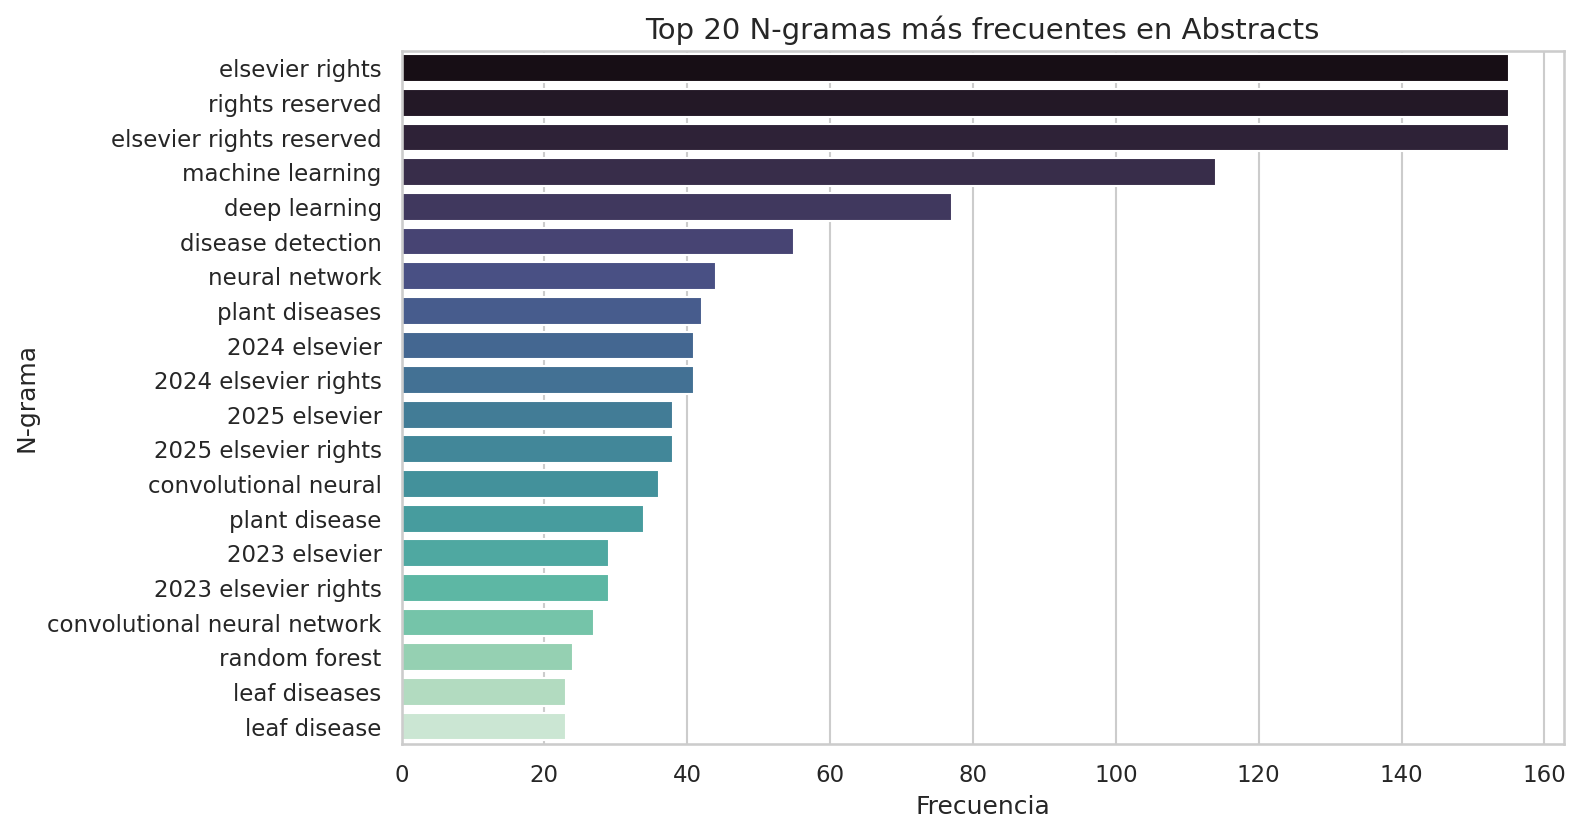

In [347]:
#N-gramas y términos en Abstracts
#Objetivo: encontrar frases comunes y términos recurrentes en los resúmenes.
# Unir todos los abstracts
abstracts = df['abstract'].fillna('').str.lower()

# N-gramas (2 y 3 palabras)
vectorizer = CountVectorizer(ngram_range=(2,3), stop_words='english').fit(abstracts)
X = vectorizer.transform(abstracts)
sum_words = X.sum(axis=0)

ngrams_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)[:20]

# DataFrame
ngram_df = pd.DataFrame(ngrams_freq, columns=['ngram', 'freq'])

# Visualizar
plt.figure(figsize=(10,6))
sns.barplot(y='ngram', x='freq', data=ngram_df, palette='mako')
plt.title("Top 20 N-gramas más frecuentes en Abstracts", fontsize=14)
plt.xlabel("Frecuencia")
plt.ylabel("N-grama")
plt.show()

/tmp/ipykernel_307540/3649950255.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = pd.to_numeric(df['year'], errors='coerce')


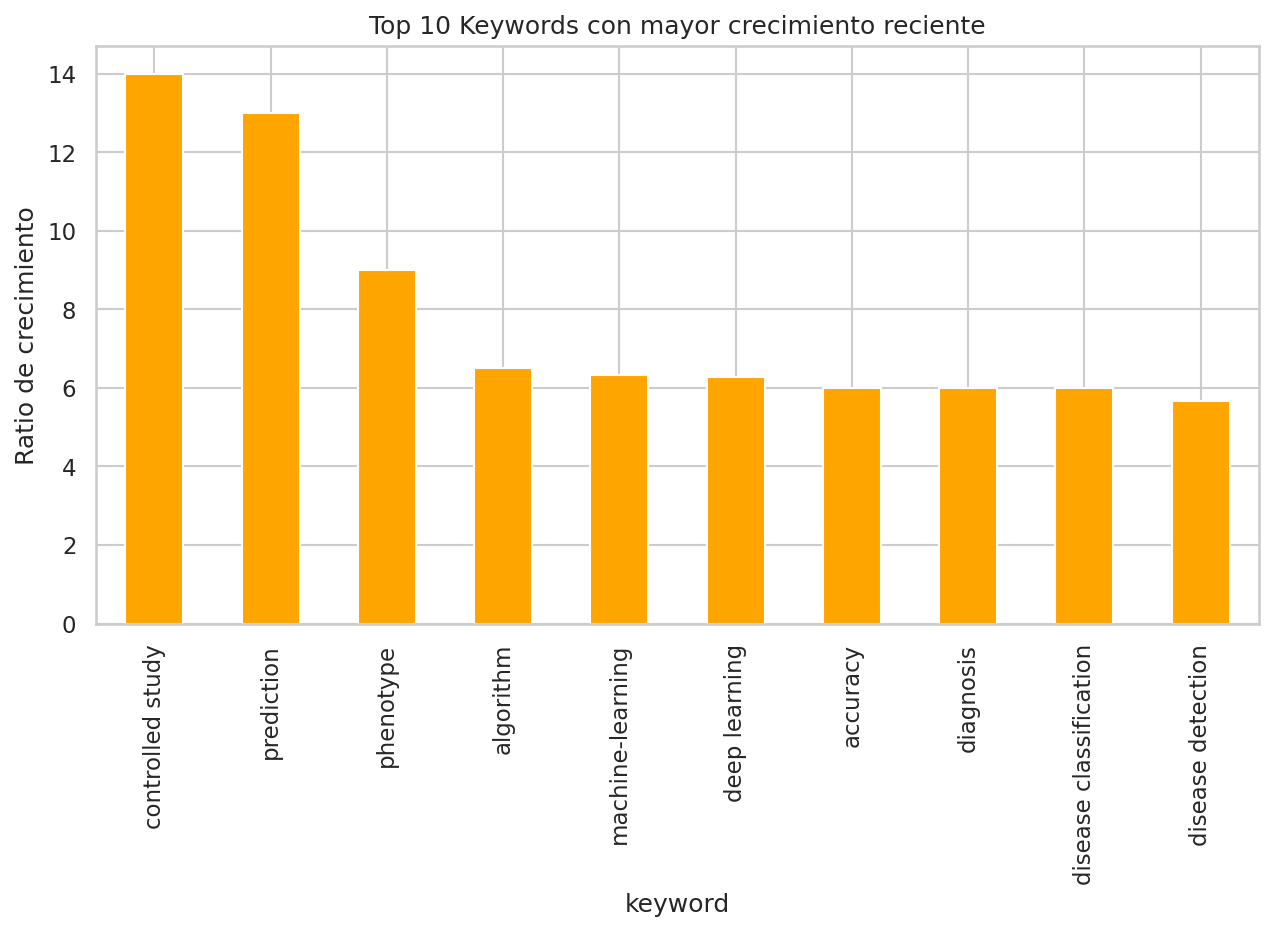

In [348]:
# Normalizamos año
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna(subset=['year'])

# Expandir keywords con año
rows = []
for _, row in df.iterrows():
    kws = (str(row['author_Keywords']) + ';' + str(row['index_keywords'])).split(';')
    for kw in kws:
        kw_clean = kw.strip().lower()
        if kw_clean:
            rows.append({'year': int(row['year']), 'keyword': kw_clean})

kw_year_df = pd.DataFrame(rows)

# Contar frecuencia por año
trend = kw_year_df.groupby(['keyword', 'year']).size().reset_index(name='count')

# Calcular crecimiento relativo (últimos 3 años vs resto)
latest_years = trend['year'].max() - 2
growth = (
    trend[trend['year'] >= latest_years]
    .groupby('keyword')['count'].sum()
    / trend[trend['year'] < latest_years]
    .groupby('keyword')['count'].sum()
)

growth = growth.sort_values(ascending=False).dropna().head(10)

# Visualizar crecimiento
growth.plot(kind='bar', figsize=(10,5), color='orange')
plt.title("Top 10 Keywords con mayor crecimiento reciente")
plt.ylabel("Ratio de crecimiento")
plt.show()

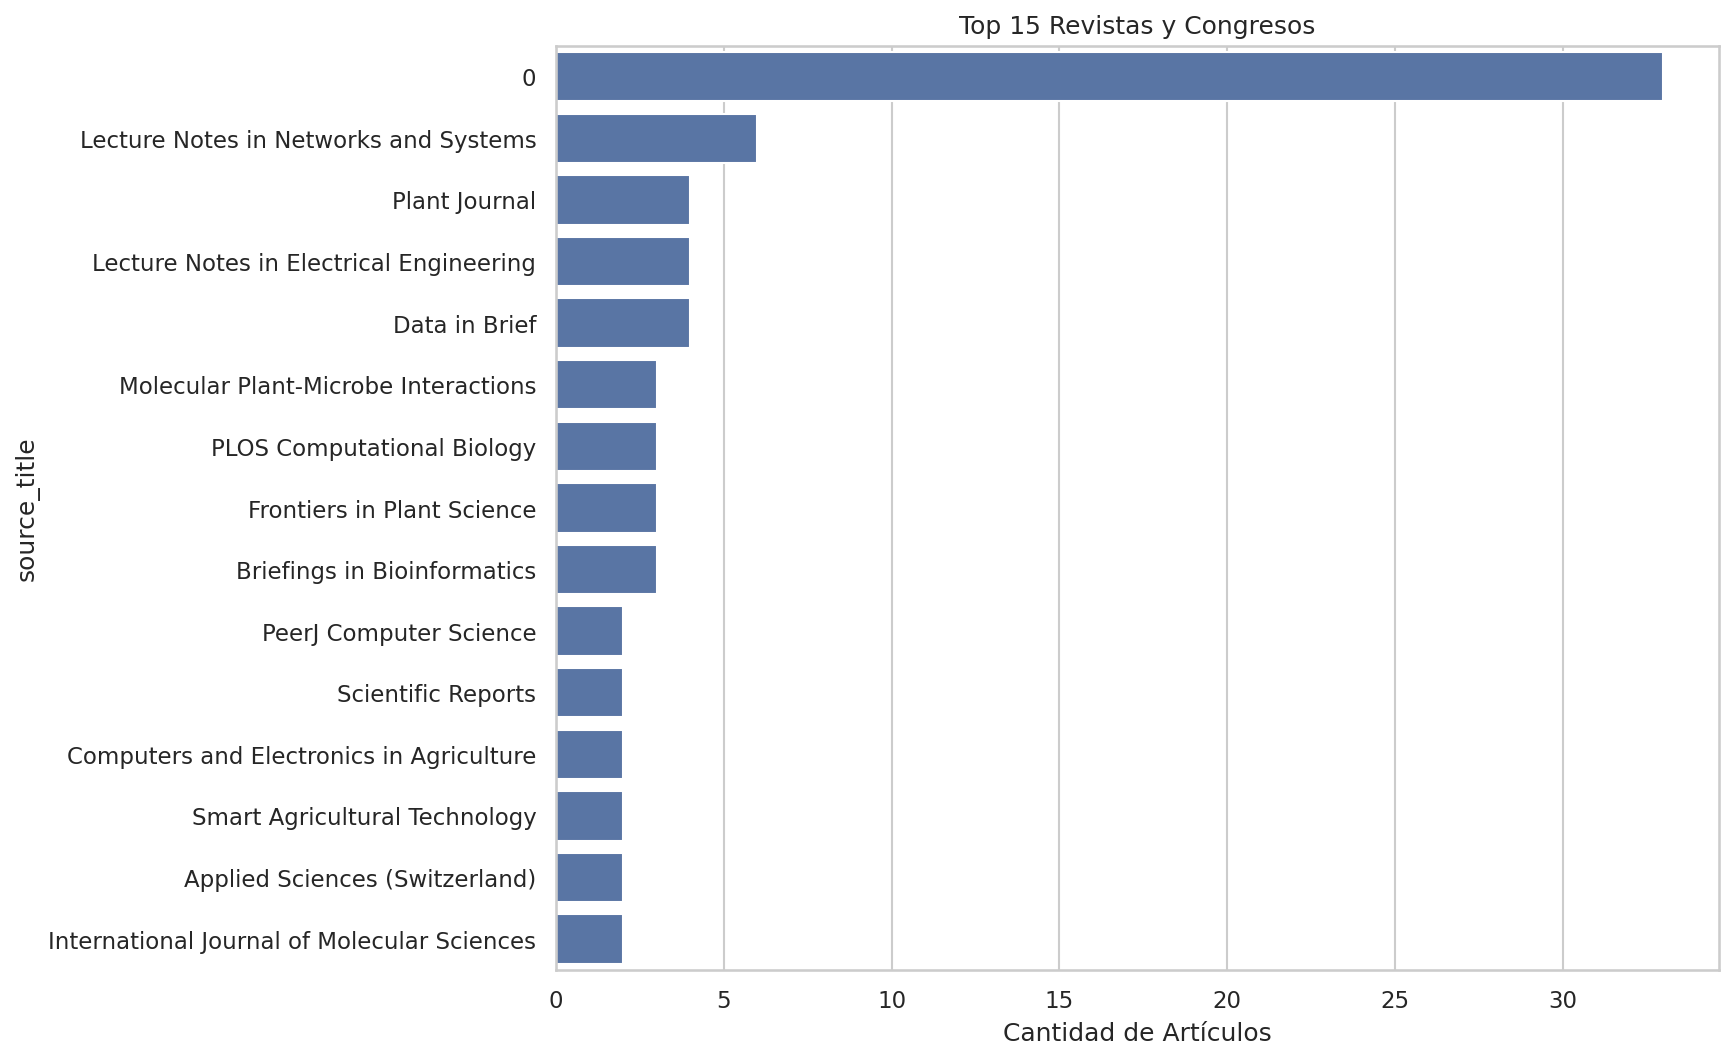

In [349]:
# Contar las 15 fuentes más comunes
top_sources = df['source_title'].value_counts().nlargest(15)

# Visualizar
plt.figure(figsize=(10, 8))
sns.barplot(x=top_sources.values, y=top_sources.index, orient='h')
plt.title('Top 15 Revistas y Congresos')
plt.xlabel('Cantidad de Artículos')
plt.show()

In [350]:
# Define el número de tópicos que quieres encontrar (esto es un hiperparámetro clave)
num_topics = 10 # Empezamos con 10 como una suposición educada

# Crea y entrena el modelo LDA
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

LatentDirichletAllocation(random_state=42)

In [351]:
# Comparación entre el DataFrame original y el enriquecido con CrossRef para algunos DOIs
import requests
import pandas as pd

# Seleccionar algunos DOIs del DataFrame original
dois_ejemplo = unified_df['DOI'].dropna().unique()[:5]  # Cambia el número para más DOIs

# Función para consultar CrossRef
def get_crossref_metadata(doi):
    url = f"https://api.crossref.org/works/{doi}"
    try:
        r = requests.get(url)
        if r.status_code == 200:
            data = r.json()['message']
            return {
                'DOI': data.get('DOI'),
                'title': data.get('title', [''])[0],
                'authors': ', '.join([a.get('family','') for a in data.get('author',[])]),
                'year': data.get('issued',{}).get('date-parts',[[None]])[0][0],
                'source_title': data.get('container-title', [''])[0],
                'volume': data.get('volume',''),
                'issue': data.get('issue',''),
                'page_start': data.get('page','').split('-')[0] if data.get('page') else '',
                'page_end': data.get('page','').split('-')[-1] if data.get('page') else '',
                'abstract': data.get('abstract','')
            }
        else:
            return None
    except Exception as e:
        return None

# Construir DataFrame enriquecido
crossref_data = [get_crossref_metadata(doi) for doi in dois_ejemplo]
crossref_df = pd.DataFrame([d for d in crossref_data if d])

# Comparar ambos DataFrames DOI por DOI
for doi in dois_ejemplo:
    print(f"\nDOI: {doi}")
    print("Original:")
    print(unified_df[unified_df['DOI']==doi][['title','authors','year','source_title']].to_string(index=False))
    print("CrossRef:")
    print(crossref_df[crossref_df['DOI']==doi][['title','authors','year','source_title']].to_string(index=False))
    crossref_df


DOI: 10.1186/s40538-025-00751-9
Original:
                                                                                                     title                                                                                                                                                                   authors  year                                        source_title
Discovery of antimicrobial peptides from Bacillus genomes against phytopathogens with deep learning models H., Su, Huan; M., Gu, Mengli; Z., Qu, Zechao; Q., Wang, Qiao; J., Jin, Jingjing; P., Lu, Peng; J., Zhang, Jianfeng; P., Cao, Peijian; X., Ren, Xueliang; J., Tao, Jiemeng  2025 Chemical and Biological Technologies in Agriculture
CrossRef:
                                                                                                     title                                             authors  year                                        source_title
Discovery of antimicrobial peptides from Bacillus genomes ag